# Web Scraping Script

**This script is borrowed from another user on Kaggle. The electricity data used for my project is scraped from this script, and is actually part of a larger Kaggle competition from the past. I made a few adjustments to get exactly the data I was interested in, and saved it as a pickle file for future use.**

---

**Site 4 is University of California Berkeley**. This is revealed in [this](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698#latest-674237) discussion post. They provide energy consumption of their building publicly in https://engagementdashboard.com/ucb/ucb/ . This is mentioned in [this](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/118039#latest-677508) discussion post already.

I captured the data transfer of engagement dashboard via developer tools in Chrome. Front-end interface communicates to backend with basic rest api calls. In this notebook, I scraped the historical energy consumption data of several buildings. Even though the web site shows 1 year data maximum, rest calls return data from 2016.

There are 91 buildings existing in ASHRAE data set already. I've found **74 buildings** correlated to UC Berkeley data set.

**There are many ways to support a study - starring it is one.**


In [9]:
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
from datetime import date, datetime, time, timedelta
import matplotlib.pyplot as plt
import pickle

## Buildings

There are 123 buildings listed in the Engagement Dashboard of UC Berkeley. They have id numbers from 173 to 292. Exceptionally, 3727, 5824 and 5992 are in the list.

In [10]:
locations = []
for i in range(173, 292+1):
    locations.append(i)

locations.append(3727)
locations.append(5824)
locations.append(5992)

## Retrieve building meta data

The first service returns the metadata of buildings. The metadata covers name of building, space use (similar to primary use feature in ASHRAE data set), time zone, built year and square feet. 

We will use square feet and built year features to match buildings in Berkeley to ASHRAE data set.

Basically, we will call the following address to get metadata: https://engagementdashboard.com/a/location/metadata?locationIds=?


In [13]:
if True:
    metadata_list = []

    pbar = tqdm(range(0, len(locations)))
    for index in pbar:
        location = locations[index]
        location_metadata = []
        http_address = "http://engagementdashboard.com/a/location/metadata?locationIds=%s" % str(location)
        print("Calling ",http_address)

        #try max 3 times
        try:
            resp = requests.get(http_address, timeout=120)
        except:
            try:
                resp = requests.get(http_address, timeout=120)
            except:
                resp = requests.get(http_address, timeout=120)

        if resp.status_code == 200:
            resp_json = resp.json()[0]

            print(resp_json)

            squareFeet = -1; year = -1
            name = ""; spaceUse = ""; address = ""; timezone = ""; resources = ""

            try: squareFeet = resp_json['areaNumber'] 
            except: pass

            try: year = resp_json['yearConstructed']
            except: pass

            try: name = resp_json["name"]
            except: pass

            try: spaceUse = resp_json["spaceUse"]
            except: pass

            try: address = resp_json["address"]
            except: pass

            try: timezone = resp_json["timeZone"]
            except: pass

            try: resources = resp_json["resources"]
            except: pass

            location_metadata.append(location)
            location_metadata.append(squareFeet)
            location_metadata.append(year)
            location_metadata.append(name)
            location_metadata.append(spaceUse)
            location_metadata.append(address)
            location_metadata.append(timezone)
            location_metadata.append(resources)

            metadata_list.append(location_metadata)

  0%|          | 0/123 [00:00<?, ?it/s]

Calling  http://engagementdashboard.com/a/location/metadata?locationIds=173


  1%|          | 1/123 [00:01<03:03,  1.50s/it]

{'areaUnit': 'SquareFeet', 'address': '37.868448, -122.262184', 'name': 'Recreational Sports Facility', 'spaceUse': 'Other', 'areaNumber': 252597, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3328', 'yearConstructed': 1984, 'id': 173}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=174


  2%|▏         | 2/123 [00:01<02:16,  1.13s/it]

{'areaUnit': 'SquareFeet', 'address': '37.880843, -122.243914', 'name': 'Silver Space Sciences Laboratory Addition', 'spaceUse': 'Laboratory', 'areaNumber': 43599, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3329', 'yearConstructed': 1998, 'id': 174}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=175


  2%|▏         | 3/123 [00:01<01:42,  1.17it/s]

{'areaUnit': 'SquareFeet', 'address': 'Berkeley, California', 'name': 'Maxwell Family Field', 'spaceUse': 'CollegeUniversity', 'areaNumber': 54000, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '4813131', 'yearConstructed': 2015, 'id': 175}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=176


  3%|▎         | 4/123 [00:02<01:18,  1.51it/s]

{'areaUnit': 'SquareFeet', 'address': '37.875511, -122.258656', 'name': 'Soda Hall', 'spaceUse': 'Laboratory', 'areaNumber': 110565, 'timeZone': 'America/Los_Angeles', 'resources': ['Steam', 'Outside', 'Electricity'], 'entityId': '3331', 'yearConstructed': 1994, 'id': 176}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=177


  4%|▍         | 5/123 [00:02<01:02,  1.87it/s]

{'areaUnit': 'SquareFeet', 'address': '37.869734, -122.258924', 'name': 'Sproul Hall', 'spaceUse': 'Administrative', 'areaNumber': 111198, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3332', 'yearConstructed': 1941, 'id': 177}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=178


  5%|▍         | 6/123 [00:02<00:52,  2.24it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871367, -122.257594', 'name': 'Stephens Hall', 'spaceUse': 'Administrative', 'areaNumber': 59548, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3333', 'yearConstructed': 1923, 'id': 178}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=179


  6%|▌         | 7/123 [00:02<00:44,  2.60it/s]

{'areaUnit': 'SquareFeet', 'address': 'Berkeley, California', 'name': 'Maxwell Garage', 'spaceUse': 'CollegeUniversity', 'areaNumber': 104000, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '4813132', 'yearConstructed': 2015, 'id': 179}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=180


  7%|▋         | 8/123 [00:03<00:38,  2.95it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873139, -122.256468', 'name': 'Tan Hall', 'spaceUse': 'Laboratory', 'areaNumber': 118376, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3334', 'yearConstructed': 1996, 'id': 180}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=181


  7%|▋         | 9/123 [00:03<00:34,  3.27it/s]

{'areaUnit': 'SquareFeet', 'address': '37.867526, -122.264193', 'name': 'Tang Center', 'spaceUse': 'Hospital', 'areaNumber': 77369, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3335', 'yearConstructed': 1993, 'id': 181}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=182


  8%|▊         | 10/123 [00:03<00:32,  3.53it/s]

{'areaUnit': 'SquareFeet', 'address': '37.874112, -122.263898', 'name': 'Tolman Hall', 'spaceUse': 'Laboratory', 'areaNumber': 246966, 'timeZone': 'America/Los_Angeles', 'resources': ['ChilledWater', 'Outside', 'Electricity'], 'entityId': '3336', 'yearConstructed': 1962, 'id': 182}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=183


  9%|▉         | 11/123 [00:03<00:30,  3.68it/s]

{'areaUnit': 'SquareFeet', 'address': '37.872023, -122.266386', 'name': 'University Hall', 'spaceUse': 'Administrative', 'areaNumber': 152987, 'timeZone': 'America/Los_Angeles', 'resources': ['Condensate', 'Water', 'Outside', 'Electricity'], 'entityId': '3337', 'yearConstructed': 1959, 'id': 183}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=184


 10%|▉         | 12/123 [00:04<00:29,  3.76it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871634, -122.262168', 'name': 'Valley Life Sciences Building', 'spaceUse': 'Laboratory', 'areaNumber': 421939, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3338', 'yearConstructed': 1930, 'id': 184}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=185


 11%|█         | 13/123 [00:04<00:28,  3.87it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873026, -122.262727', 'name': 'Wellman Hall', 'spaceUse': 'Laboratory', 'areaNumber': 44251, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3339', 'yearConstructed': 1912, 'id': 185}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=186


 11%|█▏        | 14/123 [00:04<00:27,  3.96it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871001, -122.257991', 'name': 'Moses Hall', 'spaceUse': 'CollegeUniversity', 'areaNumber': 40895, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '2628643', 'id': 186}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=187


 12%|█▏        | 15/123 [00:04<00:26,  4.01it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871326, -122.259237', 'name': 'Wheeler Hall', 'spaceUse': 'Administrative', 'areaNumber': 139735, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3340', 'yearConstructed': 1917, 'id': 187}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=188


 13%|█▎        | 16/123 [00:05<00:26,  4.08it/s]

{'areaUnit': 'SquareFeet', 'address': '37.869244, -122.261063', 'name': 'Zellerbach Hall', 'spaceUse': 'Other', 'areaNumber': 154869, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3341', 'yearConstructed': 1968, 'id': 188}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=189


 14%|█▍        | 17/123 [00:05<00:25,  4.09it/s]

{'areaUnit': 'SquareFeet', 'address': '37.875690, -122.257233', 'name': 'Upper Hearst Parking Structure', 'spaceUse': 'CollegeUniversity', 'areaNumber': 121000, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '2853179', 'id': 189}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=190


 15%|█▍        | 18/123 [00:05<00:25,  4.08it/s]

{'areaUnit': 'SquareMeters', 'address': ' 17 Gauss Way, Berkeley, CA 94720', 'name': 'MSRI ', 'spaceUse': 'CollegeUniversity', 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000477', 'id': 190}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=191


 15%|█▌        | 19/123 [00:05<00:25,  4.10it/s]

{'areaUnit': 'SquareFeet', 'address': 'Berkeley, California', 'name': 'Eshleman Hall', 'spaceUse': 'Unspecified', 'areaNumber': 64800, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '4655443', 'yearConstructed': 2015, 'id': 191}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=192


 16%|█▋        | 20/123 [00:06<00:26,  3.86it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873434, -122.264760', 'name': 'Genetics & Plant Biology ', 'spaceUse': 'Unspecified', 'areaNumber': 28453, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '2662462', 'id': 192}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=193


 17%|█▋        | 21/123 [00:06<00:25,  4.00it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873819, -122.259047', 'name': 'McLaughlin Hall', 'spaceUse': 'CollegeUniversity', 'areaNumber': 49388, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000211', 'yearConstructed': 1931, 'id': 193}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=194


 18%|█▊        | 22/123 [00:06<00:24,  4.07it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873114, -122.257017', 'name': 'Campbell Hall', 'spaceUse': 'Laboratory', 'areaNumber': 81600, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1961730', 'id': 194}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=195


 19%|█▊        | 23/123 [00:06<00:23,  4.23it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871417, -122.258533', 'name': 'South Hall', 'spaceUse': 'CollegeUniversity', 'areaNumber': 30401, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1001519', 'id': 195}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=196


 20%|█▉        | 24/123 [00:07<00:24,  4.12it/s]

{'areaUnit': 'SquareFeet', 'address': '2251 College Avenue, Berkeley, California', 'name': '2251 College Avenue', 'spaceUse': 'CollegeUniversity', 'areaNumber': 14945, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1911100', 'id': 196}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=197


 20%|██        | 25/123 [00:07<00:25,  3.88it/s]

{'areaUnit': 'SquareFeet', 'address': '2232 Piedmont Ave, Berkeley', 'name': '2232 Piedmont Ave', 'spaceUse': 'Administrative', 'areaNumber': 6706, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '2630410', 'id': 197}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=198


 21%|██        | 26/123 [00:07<00:24,  3.89it/s]

{'areaUnit': 'SquareFeet', 'address': '2234 Piedmont Ave, Berkeley', 'name': '2234 Piedmont Ave', 'spaceUse': 'Administrative', 'areaNumber': 4281, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '2630411', 'id': 198}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=199


 22%|██▏       | 27/123 [00:07<00:24,  3.86it/s]

{'areaUnit': 'SquareFeet', 'address': '37.876016, -122.258806', 'name': 'Jacobs Hall', 'spaceUse': 'CollegeUniversity', 'areaNumber': 24000, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3101448', 'yearConstructed': 2015, 'id': 199}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=200


 23%|██▎       | 28/123 [00:08<00:25,  3.78it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873413, -122.256021', 'name': 'Pimentel Hall', 'spaceUse': 'Administrative', 'areaNumber': 14524, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000255', 'id': 200}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=201


 24%|██▎       | 29/123 [00:08<00:24,  3.89it/s]

{'areaUnit': 'SquareFeet', 'address': '37.867087, -122.254864', 'name': 'Underhill Parking ', 'spaceUse': 'CollegeUniversity', 'areaNumber': 306211, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1001533', 'id': 201}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=202


 24%|██▍       | 30/123 [00:08<00:23,  4.00it/s]

{'areaUnit': 'SquareFeet', 'address': 'Berkeley, California', 'name': 'Edwards Stadium', 'spaceUse': 'CollegeUniversity', 'areaNumber': 71863, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '4817019', 'id': 202}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=203


 25%|██▌       | 31/123 [00:08<00:22,  4.07it/s]

{'areaUnit': 'SquareFeet', 'address': '37.870346, -122.261223', 'name': 'Dwinelle Annex ', 'spaceUse': 'CollegeUniversity', 'areaNumber': 8787, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1001531', 'yearConstructed': 1920, 'id': 203}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=204


 26%|██▌       | 32/123 [00:09<00:22,  4.01it/s]

{'areaUnit': 'SquareFeet', 'address': '37.869675, -122.261103', 'name': 'Alumni House ', 'spaceUse': 'CollegeUniversity', 'areaNumber': 15590, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1001530', 'yearConstructed': 1954, 'id': 204}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=205


 27%|██▋       | 33/123 [00:09<00:22,  4.00it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871565, -122.255928', 'name': "Men's Faculty Club", 'spaceUse': 'Restaurant', 'areaNumber': 35557, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '2628966', 'id': 205}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=206


 28%|██▊       | 34/123 [00:09<00:21,  4.07it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871414, -122.254678', 'name': 'Minor Hall', 'spaceUse': 'CollegeUniversity', 'areaNumber': 46225, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1960786', 'id': 206}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=207


 28%|██▊       | 35/123 [00:09<00:21,  4.03it/s]

{'areaUnit': 'SquareFeet', 'address': '2222 Piedmont Ave, Berkeley', 'name': '2222 Piedmont Ave', 'spaceUse': 'CollegeUniversity', 'areaNumber': 4085, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1960013', 'id': 207}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=208


 29%|██▉       | 36/123 [00:10<00:21,  4.01it/s]

{'areaUnit': 'SquareFeet', 'address': '37.874373, -122.259389', 'name': 'Hesse Hall', 'spaceUse': 'Administrative', 'areaNumber': 41444, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000281', 'yearConstructed': 1924, 'id': 208}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=209


 30%|███       | 37/123 [00:10<00:21,  4.07it/s]

{'areaUnit': 'SquareFeet', 'address': '37.875019,-122.258874', 'name': 'Blum Hall', 'spaceUse': 'Administrative', 'areaNumber': 26266, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000280', 'yearConstructed': 2010, 'id': 209}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=210


 31%|███       | 38/123 [00:10<00:20,  4.10it/s]

{'areaUnit': 'SquareFeet', 'address': '2200 Bancroft Way', 'name': '2200 Bancroft Way', 'spaceUse': 'Unspecified', 'areaNumber': 14468, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '4812830', 'id': 210}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=211


 32%|███▏      | 39/123 [00:10<00:19,  4.21it/s]

{'areaUnit': 'SquareFeet', 'address': '2224 Piedmont Ave, Berkeley California', 'name': '2224 Piedmont Ave', 'spaceUse': 'Administrative', 'areaNumber': 7271, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1961071', 'id': 211}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=212


 33%|███▎      | 40/123 [00:10<00:19,  4.30it/s]

{'areaUnit': 'SquareFeet', 'address': '2626 Bancroft Way\xa0Berkeley, CA 94720', 'name': 'Woo Han Fai Hall', 'spaceUse': 'Other', 'areaNumber': 105833, 'timeZone': 'America/Los_Angeles', 'resources': ['ChilledWater', 'Outside', 'Electricity'], 'entityId': '3194', 'yearConstructed': 1970, 'id': 212}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=213


 33%|███▎      | 41/123 [00:11<00:19,  4.26it/s]

Calling  http://engagementdashboard.com/a/location/metadata?locationIds=214


 34%|███▍      | 42/123 [00:11<00:18,  4.34it/s]

{'areaUnit': 'SquareFeet', 'address': '37°52\'21.9"N 122°15\'22.9"W', 'name': 'Giauque Hall', 'spaceUse': 'Administrative', 'areaNumber': 26004, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000304', 'yearConstructed': 1954, 'id': 214}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=215


 35%|███▍      | 43/123 [00:11<00:18,  4.38it/s]

{'areaUnit': 'SquareFeet', 'address': 'berkeley california', 'name': 'Lower Hearst Parking Structure', 'spaceUse': 'VehicleStorage', 'areaNumber': 140580, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3460029', 'id': 215}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=216


 36%|███▌      | 44/123 [00:11<00:18,  4.29it/s]

{'areaUnit': 'SquareFeet', 'address': '37°52\'26.2"N 122°15\'59.9"W', 'name': 'Energy Biosciences Building', 'spaceUse': 'Laboratory', 'areaNumber': 124175, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000107', 'yearConstructed': 2012, 'id': 216}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=217


 37%|███▋      | 45/123 [00:12<00:18,  4.18it/s]

{'areaUnit': 'SquareFeet', 'address': 'California Memorial Stadium, Berkeley, CA', 'name': 'California Memorial Stadium', 'spaceUse': 'Recreation', 'areaNumber': 275807, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000106', 'yearConstructed': 2012, 'id': 217}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=218


 37%|███▋      | 46/123 [00:12<00:18,  4.11it/s]

{'areaUnit': 'SquareFeet', 'address': '37.872976, -122.265337', 'name': 'Li Ka-Shing Center', 'spaceUse': 'Laboratory', 'areaNumber': 210000, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000105', 'yearConstructed': 2011, 'id': 218}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=219


 38%|███▊      | 47/123 [00:12<00:18,  4.13it/s]

{'areaUnit': 'SquareFeet', 'address': '37.874980, -122.259610', 'name': 'North Gate Hall', 'spaceUse': 'CollegeUniversity', 'areaNumber': 23745, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1717948', 'id': 219}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=220


 39%|███▉      | 48/123 [00:13<00:28,  2.62it/s]

{'areaUnit': 'SquareFeet', 'address': '2240 Piedmont Ave, Berkeley, CA', 'name': '2240 Piedmont Ave', 'spaceUse': 'Administrative', 'areaNumber': 8000, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1717949', 'id': 220}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=221


 40%|███▉      | 49/123 [00:13<00:24,  3.02it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873625N,  122.257717W', 'name': 'Evans Hall', 'spaceUse': 'Administrative', 'areaNumber': 277388, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3241', 'yearConstructed': 1971, 'id': 221}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=222


 41%|████      | 50/123 [00:13<00:22,  3.22it/s]

{'areaUnit': 'SquareFeet', 'address': '37°52\'21.4"N 122°15\'20.5"W', 'name': 'Hildebrand Hall', 'spaceUse': 'Laboratory', 'areaNumber': 135129, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3242', 'yearConstructed': 1966, 'id': 222}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=223


 41%|████▏     | 51/123 [00:14<00:21,  3.42it/s]

{'areaUnit': 'SquareFeet', 'address': '37.870533, -122.254808', 'name': 'Wurster Hall', 'spaceUse': 'Other', 'areaNumber': 225577, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3243', 'yearConstructed': 1964, 'id': 223}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=224


 42%|████▏     | 52/123 [00:14<00:19,  3.61it/s]

{'areaUnit': 'SquareFeet', 'address': '37°52\'26.1"N 122°15\'55.7"W', 'name': 'Barker Hall', 'spaceUse': 'Laboratory', 'areaNumber': 88161, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3244', 'yearConstructed': 1964, 'id': 224}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=225


 43%|████▎     | 53/123 [00:14<00:18,  3.69it/s]

{'areaUnit': 'SquareFeet', 'address': '37.869622, -122.255706', 'name': 'Hearst Tennis Courts', 'spaceUse': 'Unspecified', 'areaNumber': 38986, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '2848902', 'id': 225}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=226


 44%|████▍     | 54/123 [00:14<00:18,  3.71it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873989, -122.256047 ', 'name': 'Stanley Hall', 'spaceUse': 'Laboratory', 'areaNumber': 305641, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3246', 'yearConstructed': 2006, 'id': 226}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=227


 45%|████▍     | 55/123 [00:15<00:19,  3.46it/s]

{'areaUnit': 'SquareFeet', 'address': '37.869399, -122.255765', 'name': 'Bancroft Parking Structure', 'spaceUse': 'VehicleStorage', 'areaNumber': 38986, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '2848901', 'id': 227}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=228


 46%|████▌     | 56/123 [00:15<00:18,  3.54it/s]

{'areaUnit': 'SquareFeet', 'address': 'Berkeley, California', 'name': 'Hearst Field Annex', 'spaceUse': 'Unspecified', 'areaNumber': 31815, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '4691706', 'yearConstructed': 1999, 'id': 228}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=229


 46%|████▋     | 57/123 [00:15<00:18,  3.61it/s]

{'areaUnit': 'SquareFeet', 'address': '37.870168, -122.263920', 'name': 'Hazardous Material Facility', 'spaceUse': 'Unspecified', 'areaNumber': 23785, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '2631403', 'id': 229}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=230


 47%|████▋     | 58/123 [00:15<00:17,  3.80it/s]

{'areaUnit': 'SquareMeters', 'address': 'Berkeley, California', 'name': 'Hudson Rugby Field House', 'spaceUse': 'CollegeUniversity', 'areaNumber': 1177, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '4669828', 'id': 230}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=231


 48%|████▊     | 59/123 [00:16<00:15,  4.02it/s]

{'areaUnit': 'SquareFeet', 'address': '37°52\'21.4"N 122°15\'39.0"W', 'name': 'Moffitt Library ', 'spaceUse': 'Library', 'areaNumber': 140252, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000395', 'id': 231}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=232


 49%|████▉     | 60/123 [00:16<00:15,  4.03it/s]

{'areaUnit': 'SquareFeet', 'address': '37°52\'19.4"N 122°15\'17.9"W', 'name': "Women's Faculty Club", 'spaceUse': 'Other', 'areaNumber': 18560, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1207255', 'id': 232}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=233


 50%|████▉     | 61/123 [00:16<00:15,  3.98it/s]

{'areaUnit': 'SquareFeet', 'address': '37.874355, -122.259059', 'name': "O'Brien Hall ", 'spaceUse': 'AccountingOffice', 'areaNumber': 41822, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000393', 'yearConstructed': 1959, 'id': 233}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=234


 50%|█████     | 62/123 [00:16<00:15,  3.91it/s]

{'areaUnit': 'SquareFeet', 'address': '37.870659, -122.258214', 'name': 'Anthony Hall', 'spaceUse': 'AccountingOffice', 'areaNumber': 2010, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000904', 'id': 234}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=235


 51%|█████     | 63/123 [00:17<00:15,  3.79it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871128, -122.255660', 'name': 'Hertz Hall', 'spaceUse': 'CollegeUniversity', 'areaNumber': 31362, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1162949', 'id': 235}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=236


 52%|█████▏    | 64/123 [00:17<00:21,  2.75it/s]

{'areaUnit': 'SquareFeet', 'address': '37.874103, -122.237369', 'name': 'Botanical Gardens', 'spaceUse': 'Greenhouse', 'areaNumber': 31059, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1162948', 'id': 236}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=237


 53%|█████▎    | 65/123 [00:18<00:19,  3.05it/s]

{'areaUnit': 'SquareFeet', 'address': '37.870866, -122.256446', 'name': 'Morrison Hall', 'spaceUse': 'CollegeUniversity', 'areaNumber': 41816, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1162950', 'id': 237}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=238


 54%|█████▎    | 66/123 [00:18<00:23,  2.44it/s]

{'areaUnit': 'SquareFeet', 'address': '37.874851, -122.258522', 'name': 'Sutardja Dai Hall', 'spaceUse': 'CollegeUniversity', 'areaNumber': 141000, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1001430', 'yearConstructed': 2009, 'id': 238}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=239


 54%|█████▍    | 67/123 [00:18<00:20,  2.74it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871009, -122.253917 ', 'name': 'Calvin Laboratory ', 'spaceUse': 'MixedUseOffice', 'areaNumber': 37907, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1092809', 'id': 239}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=240


 55%|█████▌    | 68/123 [00:19<00:18,  3.04it/s]

{'areaUnit': 'SquareFeet', 'address': '2195 Hearst Ave', 'name': '2195 Hearst/SRB1', 'spaceUse': 'Administrative', 'areaNumber': 69354, 'timeZone': 'America/Los_Angeles', 'resources': ['Steam', 'Outside', 'Electricity'], 'entityId': '3290', 'yearConstructed': 2003, 'id': 240}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=241


 56%|█████▌    | 69/123 [00:19<00:16,  3.32it/s]

{'areaUnit': 'SquareFeet', 'address': '2547 Channing Way, Berkeley, CA', 'name': '2547 Channing Way', 'spaceUse': 'Administrative', 'areaNumber': 7899, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000149', 'yearConstructed': 1899, 'id': 241}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=242


 57%|█████▋    | 70/123 [00:19<00:14,  3.55it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871250, -122.260153', 'name': 'Durant Hall ', 'spaceUse': 'CollegeUniversity', 'areaNumber': 22038, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1001429', 'yearConstructed': 1911, 'id': 242}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=243


 58%|█████▊    | 71/123 [00:19<00:13,  3.76it/s]

{'areaUnit': 'SquareFeet', 'address': '', 'name': 'Barrows Hall', 'spaceUse': 'Administrative', 'areaNumber': 198294, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3291', 'yearConstructed': 1964, 'id': 243}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=244


 59%|█████▊    | 72/123 [00:20<00:13,  3.87it/s]

{'areaUnit': 'SquareFeet', 'address': '', 'name': 'Bechtel Engineering Center', 'spaceUse': 'Library', 'areaNumber': 49490, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3292', 'yearConstructed': 1980, 'id': 244}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=245


 59%|█████▉    | 73/123 [00:20<00:12,  3.96it/s]

{'areaUnit': 'SquareFeet', 'address': '', 'name': 'Birge Hall', 'spaceUse': 'Laboratory', 'areaNumber': 97032, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3293', 'yearConstructed': 1964, 'id': 245}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=246


 60%|██████    | 74/123 [00:20<00:11,  4.15it/s]

{'areaUnit': 'SquareFeet', 'address': '37°52\'12.3"N 122°15\'12.2"W', 'name': 'Berkeley Law ', 'spaceUse': 'CollegeUniversity', 'areaNumber': 367529, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3294', 'id': 246}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=247


 61%|██████    | 75/123 [00:20<00:11,  4.25it/s]

{'areaUnit': 'SquareFeet', 'address': '', 'name': 'California Hall', 'spaceUse': 'Administrative', 'areaNumber': 56399, 'timeZone': 'America/Los_Angeles', 'resources': ['Condensate', 'Water', 'Outside', 'Electricity'], 'entityId': '3295', 'yearConstructed': 1905, 'id': 247}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=248


 62%|██████▏   | 76/123 [00:21<00:10,  4.34it/s]

{'areaUnit': 'SquareFeet', 'address': '37.874903, -122.257713', 'name': 'Cory Hall', 'spaceUse': 'Laboratory', 'areaNumber': 206102, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3296', 'yearConstructed': 1950, 'id': 248}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=249


 63%|██████▎   | 77/123 [00:21<00:10,  4.43it/s]

{'areaUnit': 'SquareFeet', 'address': '37.874618, -122.258119', 'name': 'Davis Hall', 'spaceUse': 'Laboratory', 'areaNumber': 140090, 'timeZone': 'America/Los_Angeles', 'resources': ['Condensate', 'Outside', 'Electricity'], 'entityId': '3297', 'yearConstructed': 1967, 'id': 249}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=250


 63%|██████▎   | 78/123 [00:21<00:10,  4.41it/s]

{'areaUnit': 'SquareFeet', 'address': '37.872171, -122.259487', 'name': 'Doe Memorial Library', 'spaceUse': 'Library', 'areaNumber': 166779, 'timeZone': 'America/Los_Angeles', 'resources': ['Condensate', 'Outside', 'Electricity'], 'entityId': '3298', 'yearConstructed': 1917, 'id': 250}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=251


 64%|██████▍   | 79/123 [00:21<00:10,  4.31it/s]

{'areaUnit': 'SquareMeters', 'address': 'Berkeley, California', 'name': '2401 Bancroft Way', 'spaceUse': 'Unspecified', 'areaNumber': 4785, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '4655781', 'id': 251}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=252


 65%|██████▌   | 80/123 [00:22<00:14,  2.95it/s]

{'areaUnit': 'SquareFeet', 'address': '37°52\'20.8"N 122°15\'31.5"W', 'name': 'Doe Annex', 'spaceUse': 'Library', 'areaNumber': 132790, 'timeZone': 'America/Los_Angeles', 'resources': ['Condensate', 'Outside', 'Electricity'], 'entityId': '3299', 'yearConstructed': 1949, 'id': 252}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=253


 66%|██████▌   | 81/123 [00:22<00:13,  3.22it/s]

{'areaUnit': 'SquareFeet', 'address': '37.874427, -122.256367', 'name': 'Donner Laboratory', 'spaceUse': 'Laboratory', 'areaNumber': 53664, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3300', 'yearConstructed': 1942, 'id': 253}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=254


 67%|██████▋   | 82/123 [00:22<00:11,  3.42it/s]

{'areaUnit': 'SquareFeet', 'address': 'berkeley, california', 'name': 'Legends Aquatic Center', 'spaceUse': 'Unspecified', 'areaNumber': 43500, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '4949167', 'yearConstructed': 2016, 'id': 254}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=255


 67%|██████▋   | 83/123 [00:23<00:10,  3.64it/s]

{'areaUnit': 'SquareFeet', 'address': '37°52\'14.3"N 122°15\'37.6"W', 'name': 'Dwinelle Hall', 'spaceUse': 'Administrative', 'areaNumber': 305792, 'timeZone': 'America/Los_Angeles', 'resources': ['Steam', 'Water', 'Outside', 'Electricity'], 'entityId': '3301', 'yearConstructed': 1952, 'id': 255}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=256


 68%|██████▊   | 84/123 [00:23<00:10,  3.78it/s]

{'areaUnit': 'SquareFeet', 'address': 'C. V. Starr East Asian Library, Berkeley', 'name': 'East Asian Library', 'spaceUse': 'Library', 'areaNumber': 66778, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3302', 'yearConstructed': 2007, 'id': 256}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=257


 69%|██████▉   | 85/123 [00:23<00:10,  3.76it/s]

{'areaUnit': 'SquareFeet', 'address': '37.875437, -122.259202', 'name': 'Etcheverry Hall', 'spaceUse': 'Laboratory', 'areaNumber': 179722, 'timeZone': 'America/Los_Angeles', 'resources': ['Condensate', 'Outside', 'Electricity'], 'entityId': '3303', 'yearConstructed': 1964, 'id': 257}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=258


 70%|██████▉   | 86/123 [00:23<00:09,  3.73it/s]

{'areaUnit': 'SquareFeet', 'address': '37.872545, -122.256279', 'name': 'Gilman Hall ', 'spaceUse': 'CollegeUniversity', 'areaNumber': 44200, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000424', 'yearConstructed': 1917, 'id': 258}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=259


 71%|███████   | 87/123 [00:24<00:09,  3.84it/s]

{'areaUnit': 'SquareFeet', 'address': '37.872595, -122.259933', 'name': 'Gardner Stacks', 'spaceUse': 'Library', 'areaNumber': 189425, 'timeZone': 'America/Los_Angeles', 'resources': ['Condensate', 'Outside', 'Electricity'], 'entityId': '3304', 'yearConstructed': 1994, 'id': 259}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=260


 72%|███████▏  | 88/123 [00:24<00:08,  3.92it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873571, -122.254404', 'name': 'Greek Theater ', 'spaceUse': 'Other', 'areaNumber': 11910, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1001447', 'id': 260}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=261


 72%|███████▏  | 89/123 [00:24<00:08,  3.99it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873491, -122.262268', 'name': 'Giannini Hall', 'spaceUse': 'Administrative', 'areaNumber': 69580, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3305', 'yearConstructed': 1930, 'id': 261}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=262


 73%|███████▎  | 90/123 [00:24<00:08,  4.03it/s]

{'areaUnit': 'SquareFeet', 'address': '37.869754, -122.259815', 'name': 'Cesar Chavez Student Center', 'spaceUse': 'MixedUseOffice', 'areaNumber': 110959, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3306', 'yearConstructed': 1960, 'id': 262}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=263


 74%|███████▍  | 91/123 [00:25<00:08,  3.98it/s]

{'areaUnit': 'SquareFeet', 'address': '37.869328, -122.262126', 'name': 'Haas Pavilion', 'spaceUse': 'OtherClassroom', 'areaNumber': 246101, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3307', 'yearConstructed': 1933, 'id': 263}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=264


 75%|███████▍  | 92/123 [00:25<00:07,  3.97it/s]

{'areaUnit': 'SquareFeet', 'address': 'Internatinal House, Berkeley, CA', 'name': 'International House', 'spaceUse': 'Dormitory', 'areaNumber': 185212, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1000164', 'yearConstructed': 1930, 'id': 264}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=265


 76%|███████▌  | 93/123 [00:25<00:10,  2.88it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871706, -122.253589', 'name': 'Haas School of Business', 'spaceUse': 'OtherClassroom', 'areaNumber': 238270, 'timeZone': 'America/Los_Angeles', 'resources': ['Condensate', 'Outside', 'Electricity'], 'entityId': '3308', 'yearConstructed': 1995, 'id': 265}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=266


 76%|███████▋  | 94/123 [00:26<00:09,  3.10it/s]

{'areaUnit': 'SquareFeet', 'address': '37.870441, -122.256151', 'name': 'Hargrove Music Library', 'spaceUse': 'Library', 'areaNumber': 29376, 'timeZone': 'America/Los_Angeles', 'resources': ['Steam', 'Outside', 'Electricity'], 'entityId': '3309', 'yearConstructed': 2004, 'id': 266}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=267


 77%|███████▋  | 95/123 [00:26<00:12,  2.21it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873791, -122.261075', 'name': 'Haviland Hall', 'spaceUse': 'Administrative', 'areaNumber': 51200, 'timeZone': 'America/Los_Angeles', 'resources': ['Condensate', 'Outside', 'Electricity'], 'entityId': '3310', 'yearConstructed': 1924, 'id': 267}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=268


 78%|███████▊  | 96/123 [00:27<00:10,  2.56it/s]

{'areaUnit': 'SquareFeet', 'address': '37.869649, -122.256954', 'name': 'Hearst Gym', 'spaceUse': 'OtherClassroom', 'areaNumber': 124450, 'timeZone': 'America/Los_Angeles', 'resources': ['Steam', 'Outside', 'Electricity'], 'entityId': '3311', 'yearConstructed': 1927, 'id': 268}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=269


 79%|███████▉  | 97/123 [00:27<00:09,  2.88it/s]

{'areaUnit': 'SquareFeet', 'address': '37.874304, -122.257220', 'name': 'Hearst Memorial Mining', 'spaceUse': 'Laboratory', 'areaNumber': 141900, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3312', 'yearConstructed': 1907, 'id': 269}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=270


 80%|███████▉  | 98/123 [00:27<00:07,  3.15it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873250, -122.263410', 'name': 'Hilgard Hall', 'spaceUse': 'Laboratory', 'areaNumber': 77507, 'timeZone': 'America/Los_Angeles', 'resources': ['Steam', 'Water', 'Outside', 'Electricity'], 'entityId': '3313', 'yearConstructed': 1917, 'id': 270}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=271


 80%|████████  | 99/123 [00:27<00:06,  3.45it/s]

{'areaUnit': 'SquareFeet', 'address': '1952 Oxford St, Berkeley', 'name': '1952 Oxford Street', 'spaceUse': 'Administrative', 'areaNumber': 13909, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '2726616', 'id': 271}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=272


 81%|████████▏ | 100/123 [00:28<00:06,  3.58it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873958, -122.264897', 'name': 'Koshland Hall', 'spaceUse': 'Laboratory', 'areaNumber': 153979, 'timeZone': 'America/Los_Angeles', 'resources': ['Steam', 'Water', 'Outside', 'Electricity'], 'entityId': '3314', 'yearConstructed': 1990, 'id': 272}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=273


 82%|████████▏ | 101/123 [00:28<00:05,  3.76it/s]

{'areaUnit': 'SquareFeet', 'address': '37.869909, -122.255213', 'name': 'Kroeber Hall', 'spaceUse': 'Other', 'areaNumber': 119001, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3315', 'yearConstructed': 1959, 'id': 273}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=274


 83%|████████▎ | 102/123 [00:28<00:05,  3.89it/s]

{'areaUnit': 'SquareFeet', 'address': '37.872911, -122.255793', 'name': 'Latimer Hall', 'spaceUse': 'Laboratory', 'areaNumber': 195184, 'timeZone': 'America/Los_Angeles', 'resources': ['Steam', 'Water', 'Outside', 'Electricity'], 'entityId': '3316', 'yearConstructed': 1963, 'id': 274}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=275


 84%|████████▎ | 103/123 [00:28<00:05,  3.99it/s]

{'areaUnit': 'SquareFeet', 'address': '1 Centennial Dr, Berkeley', 'name': 'Lawrence Hall of Science', 'spaceUse': 'Other', 'areaNumber': 131464, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3317', 'yearConstructed': 1968, 'id': 275}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=276


 85%|████████▍ | 104/123 [00:29<00:04,  4.09it/s]

{'areaUnit': 'SquareFeet', 'address': 'Berkeley, California', 'name': 'BAMPFA', 'spaceUse': 'CollegeUniversity', 'areaNumber': 83000, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '4808380', 'yearConstructed': 2016, 'id': 276}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=277


 85%|████████▌ | 105/123 [00:29<00:04,  3.78it/s]

{'areaUnit': 'SquareFeet', 'address': '37.872295, -122.256683', 'name': 'Le Conte Hall', 'spaceUse': 'Laboratory', 'areaNumber': 69730, 'timeZone': 'America/Los_Angeles', 'resources': ['Condensate', 'Water', 'Outside', 'Electricity'], 'entityId': '3318', 'yearConstructed': 1924, 'id': 277}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=278


 86%|████████▌ | 106/123 [00:29<00:04,  3.89it/s]

{'areaUnit': 'SquareFeet', 'address': '37.880743, -122.244710', 'name': 'Silver Space Sciences Laboratory', 'spaceUse': 'CollegeUniversity', 'areaNumber': 45124, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1162983', 'id': 278}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=279


 87%|████████▋ | 107/123 [00:29<00:04,  3.95it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873, -122.255347', 'name': 'Lewis Hall', 'spaceUse': 'Laboratory', 'areaNumber': 68146, 'timeZone': 'America/Los_Angeles', 'resources': ['Steam', 'Outside', 'Electricity'], 'entityId': '3319', 'yearConstructed': 1948, 'id': 279}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=280


 88%|████████▊ | 108/123 [00:30<00:05,  2.98it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871419, -122.263267', 'name': 'Life Sciences Addition', 'spaceUse': 'Laboratory', 'areaNumber': 203427, 'timeZone': 'America/Los_Angeles', 'resources': ['Steam', 'Water', 'Outside', 'Electricity'], 'entityId': '3320', 'yearConstructed': 1988, 'id': 280}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=281


 89%|████████▊ | 109/123 [00:30<00:04,  3.27it/s]

{'areaUnit': 'SquareFeet', 'address': '2537 Haste Street', 'name': '2537 Haste Street', 'spaceUse': 'CollegeUniversity', 'areaNumber': 6500, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '4904882', 'id': 281}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=282


 89%|████████▉ | 110/123 [00:30<00:03,  3.43it/s]

{'areaUnit': 'SquareFeet', 'address': '37.874114, -122.259696', 'name': 'McCone Hall', 'spaceUse': 'Laboratory', 'areaNumber': 125731, 'timeZone': 'America/Los_Angeles', 'resources': ['Steam', 'Water', 'Outside', 'Electricity'], 'entityId': '3321', 'yearConstructed': 1961, 'id': 282}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=283


 90%|█████████ | 111/123 [00:31<00:03,  3.52it/s]

{'areaUnit': 'SquareFeet', 'address': 'Berkeley, California', 'name': 'Anna Head Complex', 'spaceUse': 'CollegeUniversity', 'areaNumber': 35000, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '4904883', 'id': 283}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=284


 91%|█████████ | 112/123 [00:31<00:03,  3.63it/s]

{'areaUnit': 'SquareFeet', 'address': '37.871123, -122.255051', 'name': 'Minor Hall Addition', 'spaceUse': 'Laboratory', 'areaNumber': 55818, 'timeZone': 'America/Los_Angeles', 'resources': ['Steam', 'Water', 'Outside', 'Electricity'], 'entityId': '3322', 'yearConstructed': 1978, 'id': 284}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=285


 92%|█████████▏| 113/123 [00:31<00:02,  3.83it/s]

{'areaUnit': 'SquareFeet', 'address': '37.869080, -122.259495', 'name': 'Martin Luther King Jr. Student Union', 'spaceUse': 'Other', 'areaNumber': 146399, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3323', 'yearConstructed': 1961, 'id': 285}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=286


 93%|█████████▎| 114/123 [00:31<00:02,  3.96it/s]

{'areaUnit': 'SquareFeet', 'address': '2000 Carleton St, Berkeley', 'name': '2000 Carleton', 'spaceUse': 'CollegeUniversity', 'areaNumber': 117135, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1205993', 'id': 286}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=287


 93%|█████████▎| 115/123 [00:32<00:01,  4.03it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873311, -122.264295', 'name': 'Morgan Hall', 'spaceUse': 'Laboratory', 'areaNumber': 57714, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3324', 'yearConstructed': 1953, 'id': 287}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=288


 94%|█████████▍| 116/123 [00:32<00:01,  4.17it/s]

{'areaUnit': 'SquareFeet', 'address': '37.872608, -122.264457', 'name': 'Mulford Hall', 'spaceUse': 'Laboratory', 'areaNumber': 93484, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3325', 'yearConstructed': 1948, 'id': 288}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=289


 95%|█████████▌| 117/123 [00:32<00:01,  4.24it/s]

{'areaUnit': 'SquareFeet', 'address': '37.870602, -122.251906', 'name': 'Simpson Center', 'spaceUse': 'CollegeUniversity', 'areaNumber': 140993, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '1158380', 'id': 289}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=290


 96%|█████████▌| 118/123 [00:32<00:01,  4.30it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873871, -122.265501', 'name': 'N.A.F', 'spaceUse': 'Laboratory', 'areaNumber': 52845, 'timeZone': 'America/Los_Angeles', 'resources': ['Condensate', 'Outside', 'Electricity'], 'entityId': '3326', 'yearConstructed': 1991, 'id': 290}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=291


 97%|█████████▋| 119/123 [00:32<00:00,  4.26it/s]

{'areaUnit': 'SquareFeet', 'address': '37.873696, -122.265848', 'name': 'Northwest Parking Garage', 'spaceUse': 'VehicleStorage', 'areaNumber': 91594, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '2726615', 'id': 291}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=292


 98%|█████████▊| 120/123 [00:33<00:00,  4.17it/s]

{'areaUnit': 'SquareFeet', 'address': '37.875274, -122.267085', 'name': 'Oxford Tract', 'spaceUse': 'Laboratory', 'areaNumber': 10535, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '3327', 'yearConstructed': 1960, 'id': 292}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=3727


 98%|█████████▊| 121/123 [00:33<00:00,  4.11it/s]

{'areaUnit': 'SquareFeet', 'address': 'Berkeley, California', 'name': 'Chou Hall', 'spaceUse': 'Unspecified', 'areaNumber': 80000, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'NaturalGas', 'Electricity'], 'entityId': '5004384', 'yearConstructed': 2018, 'id': 3727}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=5824


 99%|█████████▉| 122/123 [00:33<00:00,  4.05it/s]

{'areaUnit': 'SquareFeet', 'address': 'Berkeley, California', 'name': 'Berkeley Way West', 'spaceUse': 'CollegeUniversity', 'areaNumber': 230000, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '5009293', 'yearConstructed': 2019, 'id': 5824}
Calling  http://engagementdashboard.com/a/location/metadata?locationIds=5992


100%|██████████| 123/123 [00:33<00:00,  3.62it/s]

{'areaUnit': 'SquareFeet', 'address': 'berkeley, california', 'name': 'Anna Head Building E&F', 'spaceUse': 'Unspecified', 'areaNumber': 6169, 'timeZone': 'America/Los_Angeles', 'resources': ['Outside', 'Electricity'], 'entityId': '5009306', 'id': 5992}


In [14]:
source = pd.DataFrame(metadata_list, columns = ['source_id', 'square_feet', 'year', 'name', 'spaceUse', 'address', 'timezone', 'resources'])

In [15]:
source.head(10)

source_id  square_feet  year                                       name  \
0        173       252597  1984               Recreational Sports Facility   
1        174        43599  1998  Silver Space Sciences Laboratory Addition   
2        175        54000  2015                       Maxwell Family Field   
3        176       110565  1994                                  Soda Hall   
4        177       111198  1941                                Sproul Hall   
5        178        59548  1923                              Stephens Hall   
6        179       104000  2015                             Maxwell Garage   
7        180       118376  1996                                   Tan Hall   
8        181        77369  1993                                Tang Center   
9        182       246966  1962                                Tolman Hall   

            spaceUse                 address             timezone  \
0              Other  37.868448, -122.262184  America/Los_Angeles   
1         Laboratory  37.880843, -122.243914  America/Los_Angeles   
2  CollegeUniversity    Berkeley, California  America/Los_Angeles   
3         Laboratory  37.875511, -122.258656  America/Los_Angeles   
4     Administrative  37.869734, -122.258924  America/Los_Angeles   
5     Administrative  37.871367, -122.257594  America/Los_Angeles   
6  CollegeUniversity    Berkeley, California  America/Los_Angeles   
7         Laboratory  37.873139, -122.256468  America/Los_Angeles   
8           Hospital  37.867526, -122.264193  America/Los_Angeles   
9         Laboratory  37.874112, -122.263898  America/Los_Angeles   

                              resources  
0                [Outside, Electricity]  
1                [Outside, Electricity]  
2                [Outside, Electricity]  
3         [Steam, Outside, Electricity]  
4                [Outside, Electricity]  
5                [Outside, Electricity]  
6                [Outside, Electricity]  
7                [Outside, Electricity]  
8                [Outside, Electricity]  
9  [ChilledWater, Outside, Electricity]

## Building metadata in ASHRAE data set 

In [16]:
target = pd.read_csv("ashrae-energy-prediction/building_metadata.csv")

In [17]:
target.head()

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

In [18]:
#we believe that UC Berkeley is site id 4. Filter target data frame for just site 4.
target = target[target['site_id'] == 4]

In [19]:
print("There are ",len(target.building_id.unique())," buildings in ASHRAE data set")

There are  91  buildings in ASHRAE data set


In [20]:
ashrae_buildings = target.building_id.unique()

In [21]:
train_df = pd.read_csv("ashrae-energy-prediction/train.csv")
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df = train_df[train_df.building_id.isin(ashrae_buildings)]

In [22]:
train_df.head()

building_id  meter  timestamp  meter_reading
722          565      0 2016-01-01          7.250
723          566      0 2016-01-01          0.519
724          569      0 2016-01-01        246.000
725          570      0 2016-01-01         79.488
726          571      0 2016-01-01         17.000

## Consumption data for found locations

We will call the following service to retrieve consumption data. It basically expects location in Berkeley data set, start time and end time.

My experiments show that the service could return max 6 months data for hourly period. That's why, I will call half periods for years 2016, 2017 and 2018.

https://engagementdashboard.com/a/consumption?endTime=?&granularity=HOUR&locationIds=?&resource=Electricity&startTime=?

Notice that site 4 has just 0 meter type (electricity) in ASHRAE data set. That's why, I passed resource to Electricity.

To speed kernel up, I saved this block's results in the **berkeley_consumptions.csv** file. You can still call retrieveConsumptions functions to get consumption data.

I will call consumption service for both catched buildings and close buildings. That's why, I've written a generic function to call.

In [96]:
def retrieveConsumptions(locations): 
    consumption_list = []
    for index in range(0, len(locations)):
        location = locations[index]
        print(index+1,'/',len(locations), ".",int(location), ".", end='')
        for year in range(2016, 2020):
            print(year, "",end= '')
            for half in range(0, 2):
#                 if year == 2019 and half == 1: #2019 2nd period is not completed yet (today is 2019-11-23)
#                     break
                if half == 0:
                    print("1/2 ", end='')
#                     if year == 2019:
#                         http_address = "https://engagementdashboard.com/a/consumption?endTime="+str(year)+"-01-01T23:59:59.000Z&granularity=HOUR&locationIds="+str(int(location))+"&resource=Electricity&startTime="+str(year)+"-01-01T00:00:00.000Z"
#                     else:
                    http_address = "https://engagementdashboard.com/a/consumption?endTime="+str(year)+"-06-31T23:59:59.000Z&granularity=HOUR&locationIds="+str(int(location))+"&resource=Electricity&startTime="+str(year)+"-01-01T00:00:00.000Z"
                else:
                    print("2/2. ", end='')
                    http_address = "https://engagementdashboard.com/a/consumption?endTime="+str(year)+"-12-31T23:59:59.000Z&granularity=HOUR&locationIds="+str(int(location))+"&resource=Electricity&startTime="+str(year)+"-07-01T00:00:00.000Z"

                #print(http_address)
                
                #try maximum 4 times
                try:
                    resp = requests.get(http_address, timeout=120)
                except:
                    try:
                        resp = requests.get(http_address, timeout=120)
                    except:
                        try:
                            resp = requests.get(http_address, timeout=120)
                        except:
                            resp = requests.get(http_address, timeout=120)
                
                if resp.status_code == 200:
                    resp_json = resp.json()[0]
                    #print(resp_json)
                    consumptions = resp_json["actual"]["data"]
                    #consumptions = resp_json["baseline"]["data"]
                    for i in consumptions:

                        consumption = []

                        value = i["value"]
                        timestamp = i["timestamp"]
                        
                        trx_datetime = datetime.fromtimestamp(timestamp)
#                         + timedelta(hours=-8) 
                        consumption.append(location)
                        consumption.append(str(trx_datetime))
                        consumption.append(value)
                        
                        consumption_list.append(consumption)
                else:
                    print("Error code ",resp.status_code," returned for building ",location," ",year," ",half)
        print("")    
    return consumption_list

In [84]:
# def retrieveConsumptions2019(locations): 
#     consumption_list = []
#     for index in range(0, len(locations)):
#         location = locations[index]
#         print(index+1,'/',len(locations), ".",int(location), ".", end='')
#         for year in range(2019, 2020):
#             print(year, "",end= '')
#             for half in range(0, 2):
# #                 if year == 2019 and half == 1: #2019 2nd period is not completed yet (today is 2019-11-23)
# #                     break
#                 if half == 0:
#                     print("1/2 ", end='')
# #                     if year == 2019:
# #                         http_address = "https://engagementdashboard.com/a/consumption?endTime="+str(year)+"-01-01T23:59:59.000Z&granularity=HOUR&locationIds="+str(int(location))+"&resource=Electricity&startTime="+str(year)+"-01-01T00:00:00.000Z"
# #                     else:
#                     http_address = "https://engagementdashboard.com/a/consumption?endTime="+str(year)+"-06-31T23:59:59.000Z&granularity=HOUR&locationIds="+str(int(location))+"&resource=Electricity&startTime="+str(year)+"-01-01T00:00:00.000Z"
#                 else:
#                     print("2/2. ", end='')
#                     http_address = "https://engagementdashboard.com/a/consumption?endTime="+str(year)+"-12-01T23:59:59.000Z&granularity=HOUR&locationIds="+str(int(location))+"&resource=Electricity&startTime="+str(year)+"-07-01T00:00:00.000Z"

#                 #print(http_address)
                
#                 #try maximum 4 times
#                 try:
#                     resp = requests.get(http_address, timeout=120)
#                 except:
#                     try:
#                         resp = requests.get(http_address, timeout=120)
#                     except:
#                         try:
#                             resp = requests.get(http_address, timeout=120)
#                         except:
#                             resp = requests.get(http_address, timeout=120)
                
#                 if resp.status_code == 200:
#                     resp_json = resp.json()[0]
#                     #print(resp_json)
#                     consumptions = resp_json["actual"]["data"]
#                     #consumptions = resp_json["baseline"]["data"]
#                     for i in consumptions:

#                         consumption = []

#                         value = i["value"]
#                         timestamp = i["timestamp"]
                        
#                         trx_datetime = datetime.fromtimestamp(timestamp)
# #                         + timedelta(hours=-8) 
#                         consumption.append(location)
#                         consumption.append(str(trx_datetime))
#                         consumption.append(value)
                        
#                         consumption_list.append(consumption)
#                 else:
#                     print("Error code ",resp.status_code," returned for building ",location," ",year," ",half)
#         print("")    
#     return consumption_list

In [138]:
# # you can activate this block to retrieve data from the service
# consumptions2019 = retrieveConsumptions2019(locations)

In [93]:
# leak2019 = pd.DataFrame(consumptions2019, columns=['berkeley_id', 'timestamp', 'meter_reading'])
# leak2019['timestamp'] = pd.to_datetime(leak2019['timestamp'])
# leak2019 = leak2019[leak2019.timestamp.dt.year >= 2019]

In [94]:
# leak2019

berkeley_id           timestamp  meter_reading
16              173 2019-01-01 00:00:00         103.00
17              173 2019-01-01 01:00:00         102.00
18              173 2019-01-01 02:00:00         103.00
19              173 2019-01-01 03:00:00         117.00
20              173 2019-01-01 04:00:00         121.00
...             ...                 ...            ...
988915         5992 2019-12-01 03:00:00           2.33
988916         5992 2019-12-01 04:00:00           2.42
988917         5992 2019-12-01 05:00:00           2.46
988918         5992 2019-12-01 06:00:00           2.48
988919         5992 2019-12-01 07:00:00           2.52

[986952 rows x 3 columns]

### Get meter readings for 2016 to present

In [97]:
# you can activate this block to retrieve data from the service
consumptions = retrieveConsumptions(locations)
leak2 = pd.DataFrame(consumptions, columns=['berkeley_id', 'timestamp', 'meter_reading'])
leak2['timestamp'] = pd.to_datetime(leak2['timestamp'])
leak2 = leak2[leak2.timestamp.dt.year >= 2016]

# leak = pd.read_csv("ashrae-energy-prediction/berkeley_consumptions.csv")
leak2['timestamp'] = pd.to_datetime(leak2['timestamp'])

1 / 123 . 173 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
2 / 123 . 174 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
3 / 123 . 175 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
4 / 123 . 176 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
5 / 123 . 177 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
6 / 123 . 178 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
7 / 123 . 179 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
8 / 123 . 180 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
9 / 123 . 181 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
10 / 123 . 182 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
11 / 123 . 183 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
12 / 123 . 184 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
13 / 123 . 185 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 2/2. 
14 / 123 . 186 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 20

In [34]:
# with open('berkeley_meter_readings.pkl', 'wb') as to_write:
#     pickle.dump(leak, to_write)

In [127]:
with open('berkeley_all_readings.pkl','rb') as read_file:
    leak2 = pickle.load(read_file)

In [128]:
leak2 = leak2.sort_values(by = 'timestamp').reset_index()

In [129]:
# Remove all 12/2019 values (most are NaN since they haven't happened yet)

leak2 = leak2[leak2['timestamp'] < '2019-12-01 00:00:00']

In [132]:
leak2 = leak2.sort_values(by='index')

In [134]:
leak2 = leak2.set_index('index')

In [136]:
# with open('berkeley_all_readings.pkl', 'wb') as to_write:
#     pickle.dump(leak2, to_write)

## Scraping meter readings (does not take UTC time shift into account)

In [86]:
with open('berkeley_meter_readings.pkl','rb') as read_file:
    berkeley_meter_readings = pickle.load(read_file)

In [87]:
berkeley_meter_readings

berkeley_id           timestamp  meter_reading
16               173 2016-01-01 00:00:00           85.0
17               173 2016-01-01 01:00:00           93.0
18               173 2016-01-01 02:00:00           92.0
19               173 2016-01-01 03:00:00          106.0
20               173 2016-01-01 04:00:00          108.0
...              ...                 ...            ...
3238339         5992 2019-01-01 03:00:00            NaN
3238340         5992 2019-01-01 04:00:00            NaN
3238341         5992 2019-01-01 05:00:00            NaN
3238342         5992 2019-01-01 06:00:00            NaN
3238343         5992 2019-01-01 07:00:00            NaN

[3236376 rows x 3 columns]

In [82]:
type(berkeley_meter_readings['timestamp'][16])

pandas._libs.tslibs.timestamps.Timestamp

In [49]:
berkeley_buildings = list(leak.berkeley_id.unique())

## Analysis - matching building ID's with ASHRAE ID's

In [50]:
correlation_threshold = 0.79 # we will expect correlation coefficient higher than this value
mae_correlation = 10 #mean absolute error of berkeley and ashrae data should have less than this value

1 . berkeley  176  is highly correlated to ashrae  641  with score  0.9590833318931183
mae:  10.155283903383845  whereas mean:  434.85790999202464  mae / mean:  2.3353108383310985 %


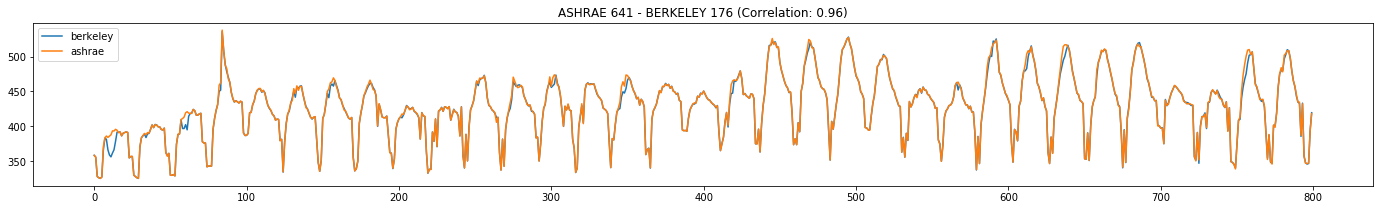

------------------------------------
2 . berkeley  177  is highly correlated to ashrae  643  with score  0.9767549442427095
mae:  3.3143732802003867  whereas mean:  89.98190844813847  mae / mean:  3.6833774003700337 %


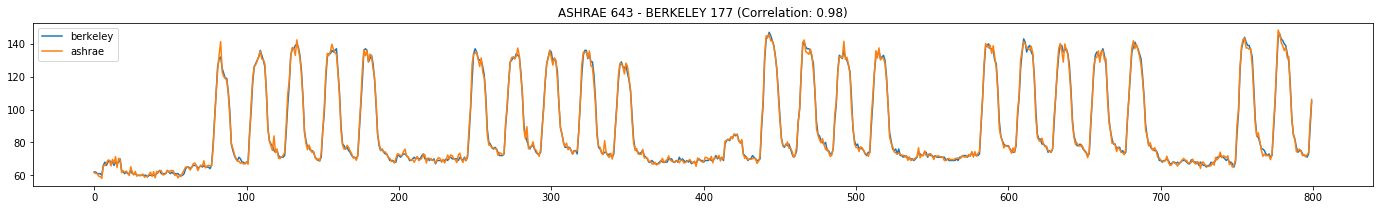

------------------------------------
3 . berkeley  178  is highly correlated to ashrae  646  with score  0.9649158779164706
mae:  2.918957991346921  whereas mean:  42.40780019355573  mae / mean:  6.883068628941721 %


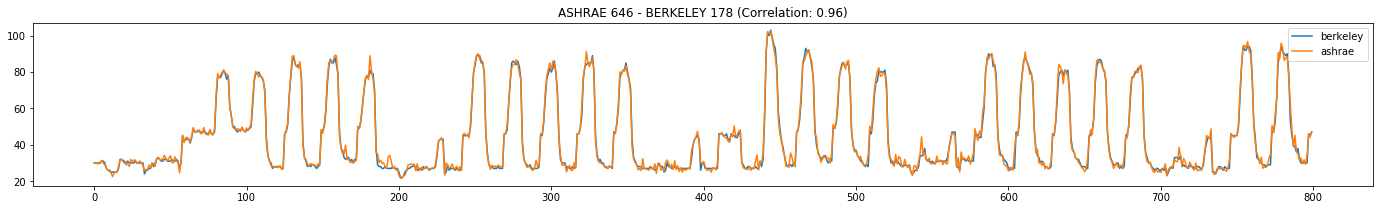

------------------------------------
4 . berkeley  179  is highly correlated to ashrae  621  with score  0.821116294656191
mae:  1.1685639781188766  whereas mean:  16.58123758981058  mae / mean:  7.0475075927805095 %


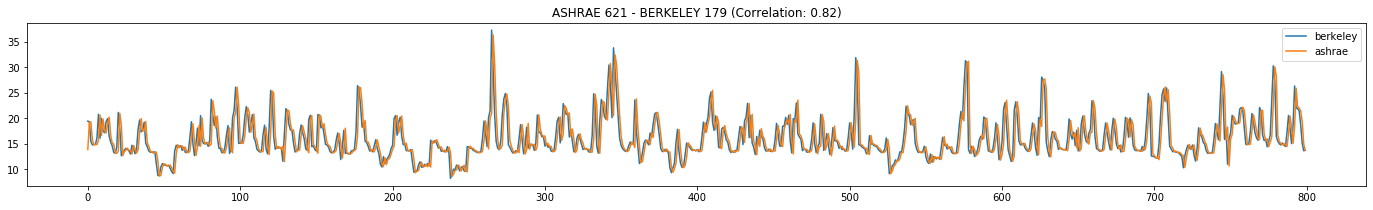

------------------------------------
5 . berkeley  180  is highly correlated to ashrae  649  with score  0.9461953599169125
mae:  7.731302611091571  whereas mean:  432.6084858717317  mae / mean:  1.7871361435531108 %


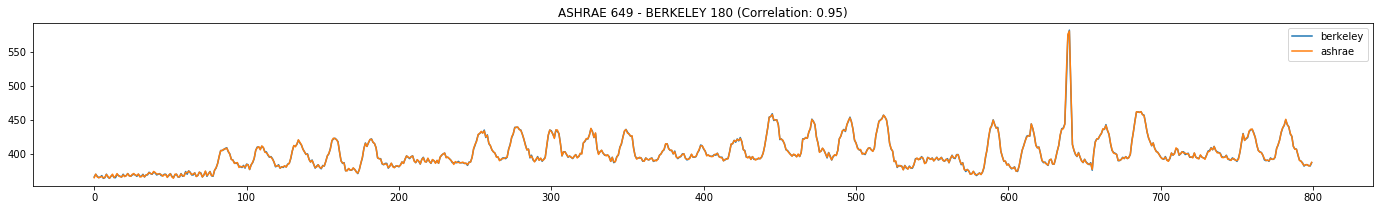

------------------------------------
6 . berkeley  183  is highly correlated to ashrae  652  with score  0.9678496040220638
mae:  6.395274327444723  whereas mean:  114.22025784134944  mae / mean:  5.59907187070763 %


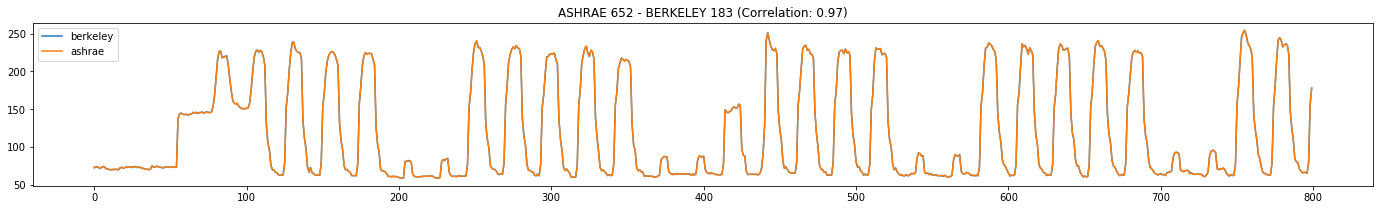

------------------------------------
7 . berkeley  184  is highly correlated to ashrae  653  with score  0.9823850960994991
mae:  17.989462487159  whereas mean:  939.1153140052505  mae / mean:  1.9155754590387204 %


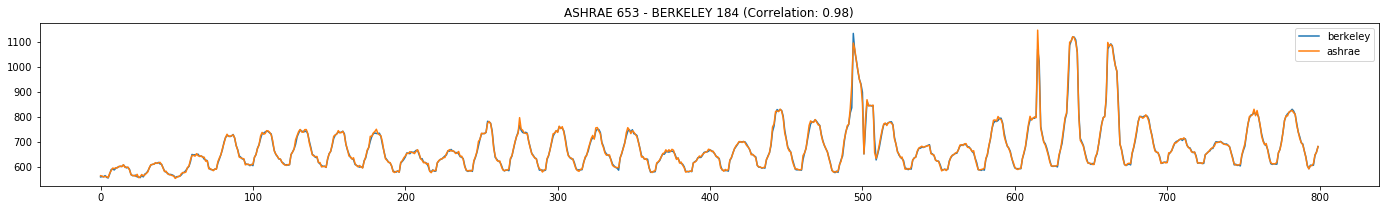

------------------------------------
8 . berkeley  185  is highly correlated to ashrae  654  with score  0.9387185886323944
mae:  1.017627573408154  whereas mean:  51.17722213696747  mae / mean:  1.9884384710929406 %


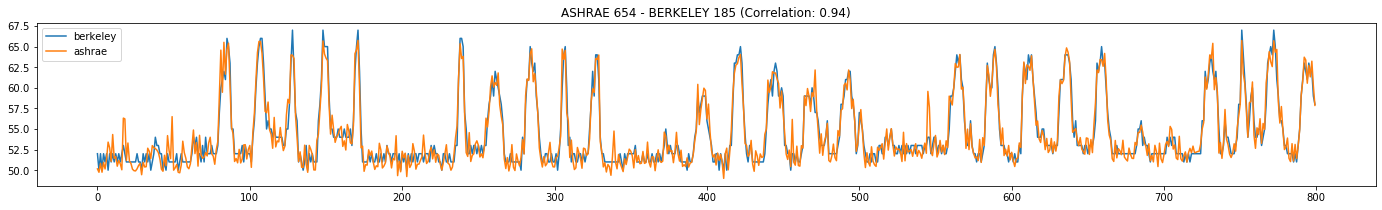

------------------------------------


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


9 . berkeley  188  is highly correlated to ashrae  655  with score  0.9552003717340299
mae:  6.830671362860071  whereas mean:  141.60398530114995  mae / mean:  4.8237846896280825 %


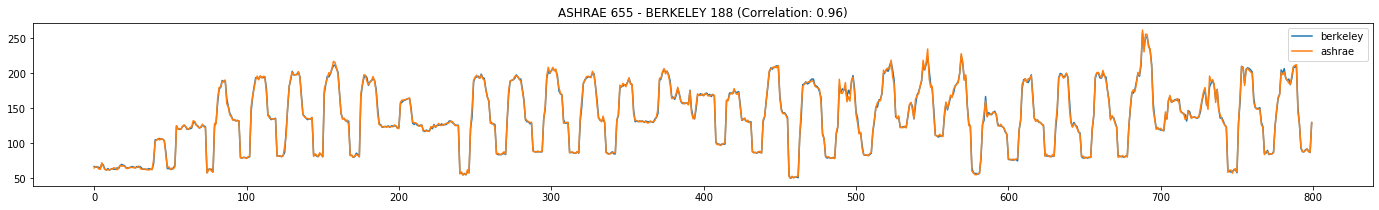

------------------------------------
10 . berkeley  193  is highly correlated to ashrae  623  with score  0.9572690282351415
mae:  1.6657218708869406  whereas mean:  23.855271911647502  mae / mean:  6.982615318979618 %


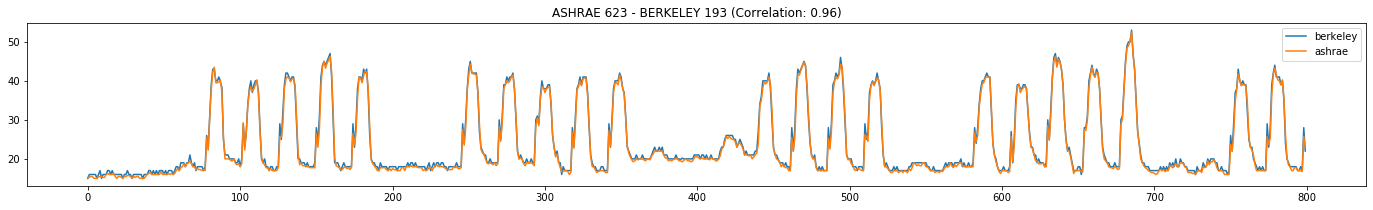

------------------------------------
11 . berkeley  194  is highly correlated to ashrae  576  with score  0.974899218597323
mae:  3.473528696345212  whereas mean:  153.56372913583058  mae / mean:  2.2619460440901364 %


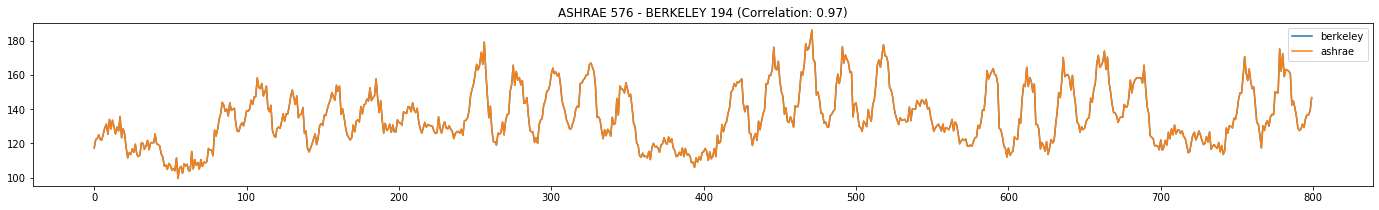

------------------------------------
12 . berkeley  195  is highly correlated to ashrae  642  with score  0.9587768078687597
mae:  1.1270623460662643  whereas mean:  13.439331663440736  mae / mean:  8.386297580051789 %


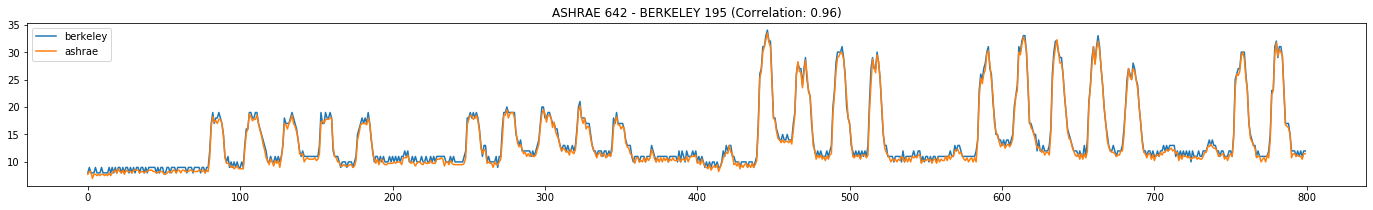

------------------------------------
13 . berkeley  196  is highly correlated to ashrae  582  with score  0.8179166688061862
mae:  0.48717083262362637  whereas mean:  6.398081433150184  mae / mean:  7.614326852725928 %


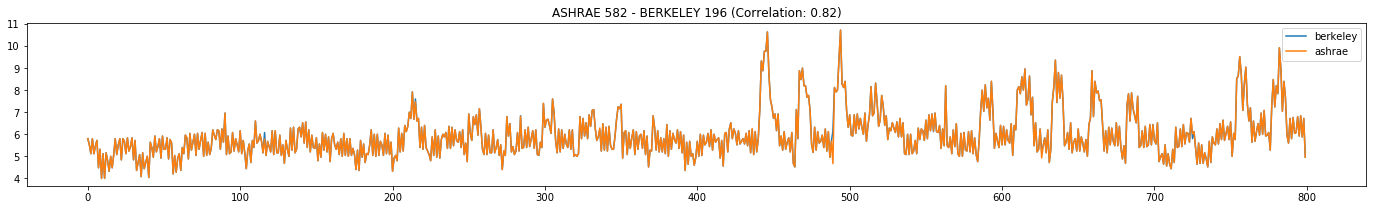

------------------------------------
14 . berkeley  197  is highly correlated to ashrae  636  with score  0.9578766740869746
mae:  0.012991346786397814  whereas mean:  0.18448662565504673  mae / mean:  7.041890836406238 %


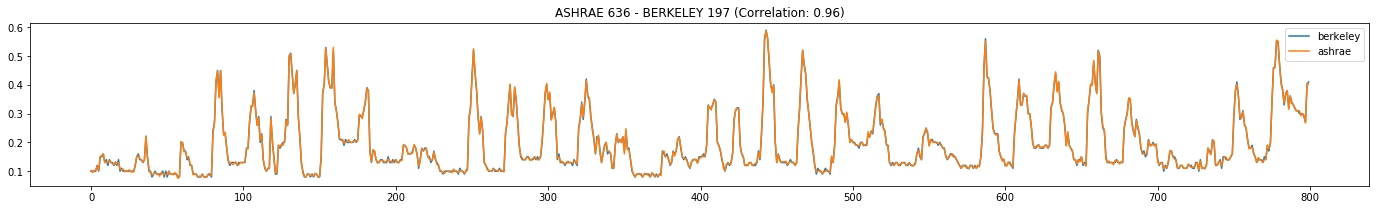

------------------------------------
15 . berkeley  198  is highly correlated to ashrae  637  with score  0.952214662408981
mae:  0.01830233337982709  whereas mean:  0.2000814178674352  mae / mean:  9.147442863461404 %


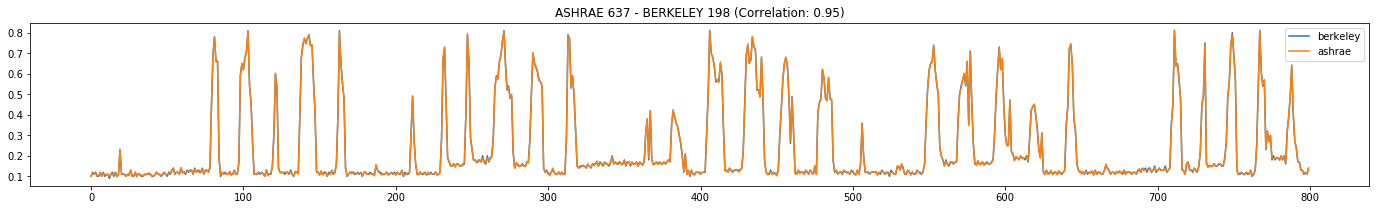

------------------------------------
16 . berkeley  204  is highly correlated to ashrae  565  with score  0.9569939401863656
mae:  1.0204936043280182  whereas mean:  10.50443922551253  mae / mean:  9.714879418308279 %


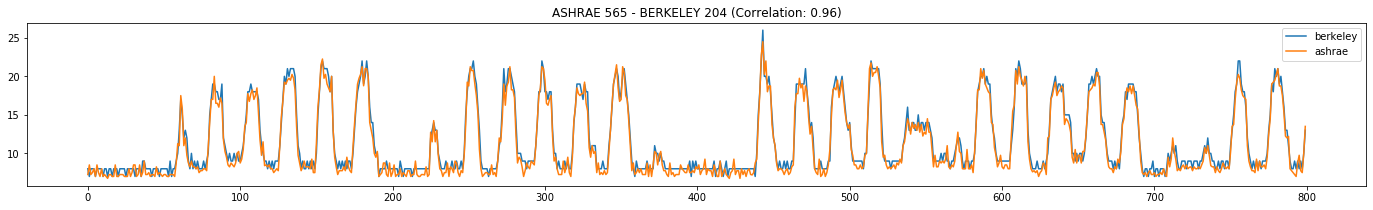

------------------------------------
17 . berkeley  206  is highly correlated to ashrae  624  with score  0.9637372119686761
mae:  2.707997513605829  whereas mean:  94.31948033701468  mae / mean:  2.871090366411937 %


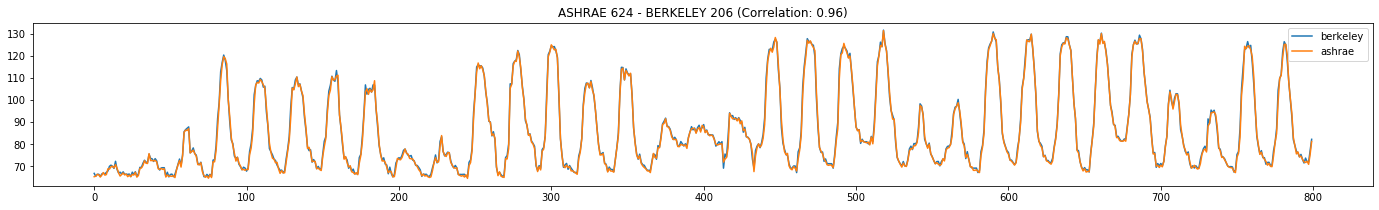

------------------------------------
18 . berkeley  207  is highly correlated to ashrae  634  with score  0.9514260944933242
mae:  0.020727779141523395  whereas mean:  0.2981758624615735  mae / mean:  6.951528192257555 %


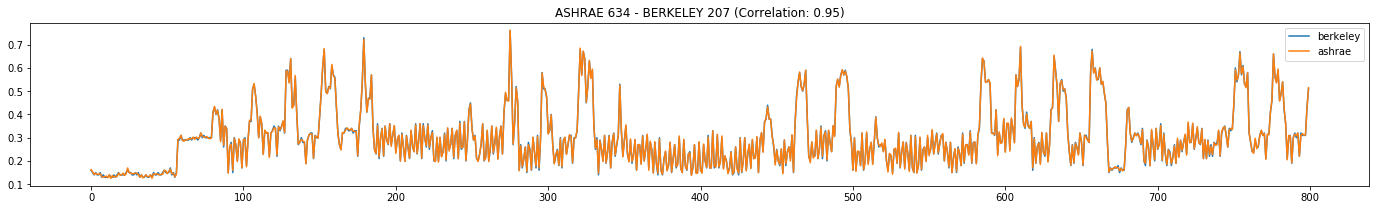

------------------------------------
19 . berkeley  209  is highly correlated to ashrae  573  with score  0.96179242773017
mae:  0.7118227128543778  whereas mean:  13.59610589775703  mae / mean:  5.235489618919549 %


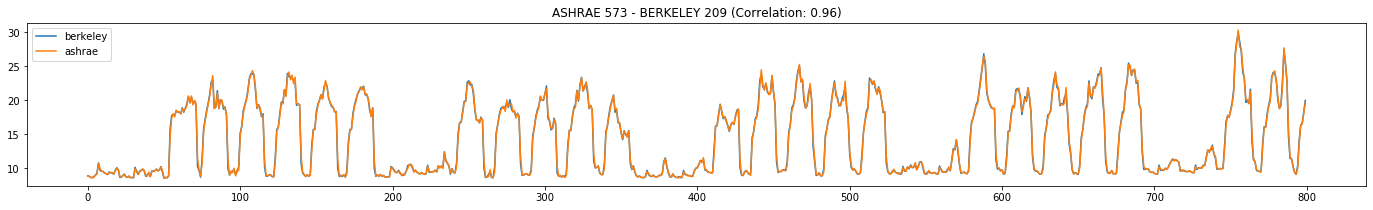

------------------------------------
20 . berkeley  210  is highly correlated to ashrae  568  with score  0.9582213952809897
mae:  0.480996197392359  whereas mean:  5.708580867192238  mae / mean:  8.425845382285646 %


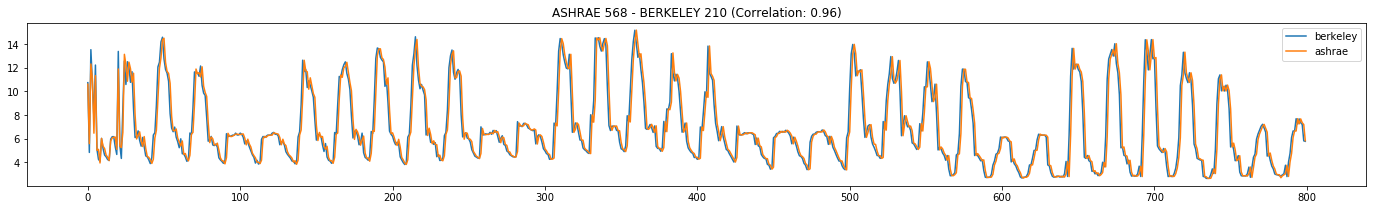

------------------------------------
21 . berkeley  211  is highly correlated to ashrae  635  with score  0.9482643159504877
mae:  0.10108822637106184  whereas mean:  3.485553523920653  mae / mean:  2.9002058260564256 %


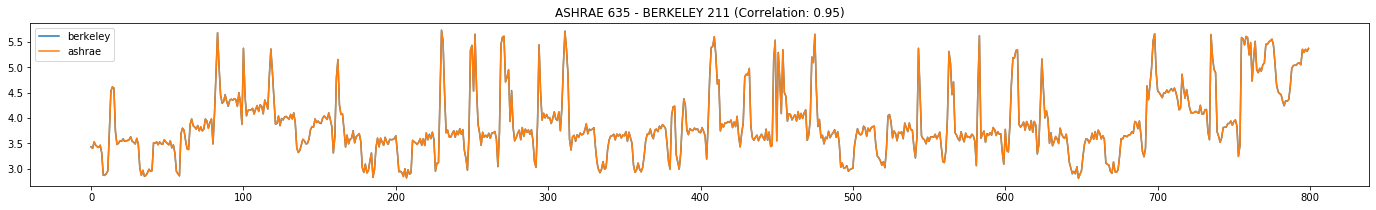

------------------------------------
22 . berkeley  214  is highly correlated to ashrae  599  with score  0.9750064245177452
mae:  2.806971259023113  whereas mean:  93.25218694068086  mae / mean:  3.0100862522491516 %


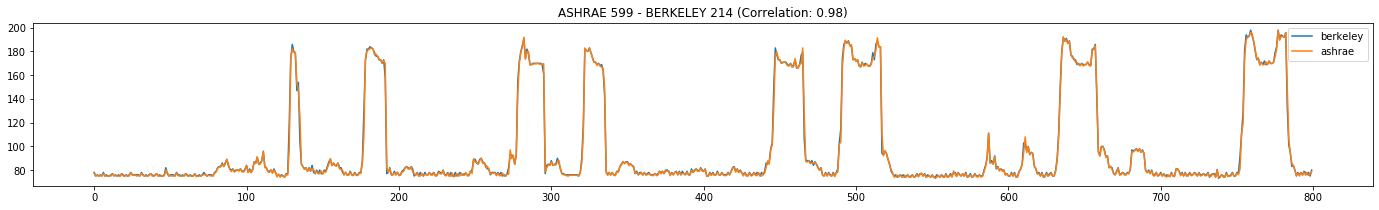

------------------------------------
23 . berkeley  216  is highly correlated to ashrae  592  with score  0.9298724687536335
mae:  10.035731280328054  whereas mean:  393.11825993848964  mae / mean:  2.552852996932354 %


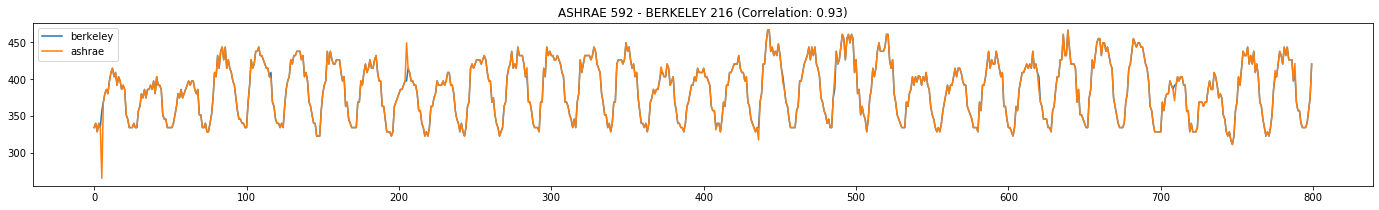

------------------------------------
24 . berkeley  217  is highly correlated to ashrae  644  with score  0.897158930250951
mae:  13.63696017425198  whereas mean:  259.92605571477696  mae / mean:  5.246476786158038 %


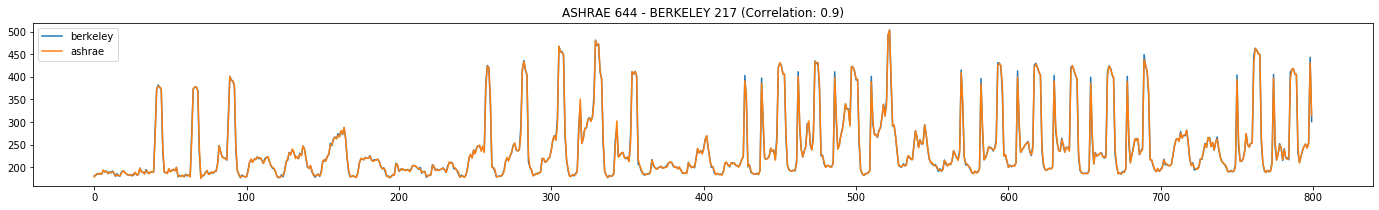

------------------------------------
25 . berkeley  218  is highly correlated to ashrae  620  with score  0.9746968333114044
mae:  17.734114630536265  whereas mean:  1299.2475361493794  mae / mean:  1.3649527235660894 %


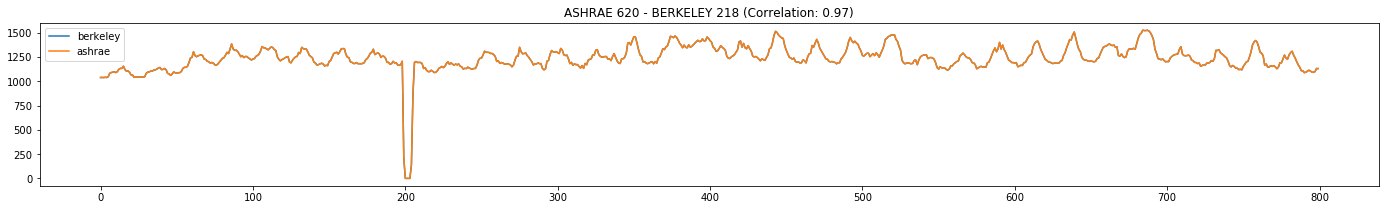

------------------------------------
26 . berkeley  219  is highly correlated to ashrae  631  with score  0.9495427322589941
mae:  0.632856315564158  whereas mean:  12.5924939314585  mae / mean:  5.025663057761416 %


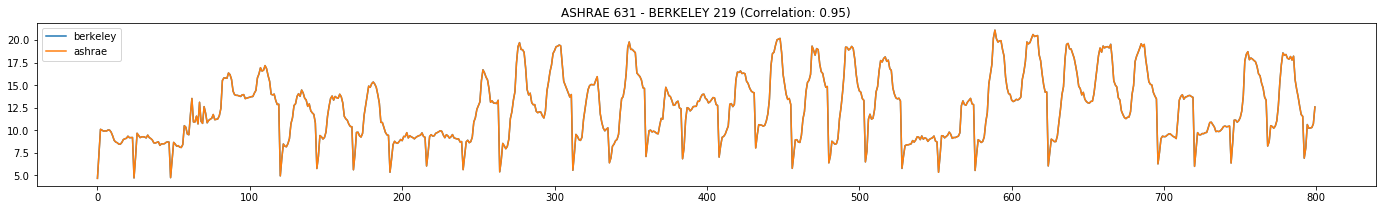

------------------------------------
27 . berkeley  220  is highly correlated to ashrae  638  with score  0.9597666836540494
mae:  0.18120959808721393  whereas mean:  3.64277421154503  mae / mean:  4.97449437060653 %


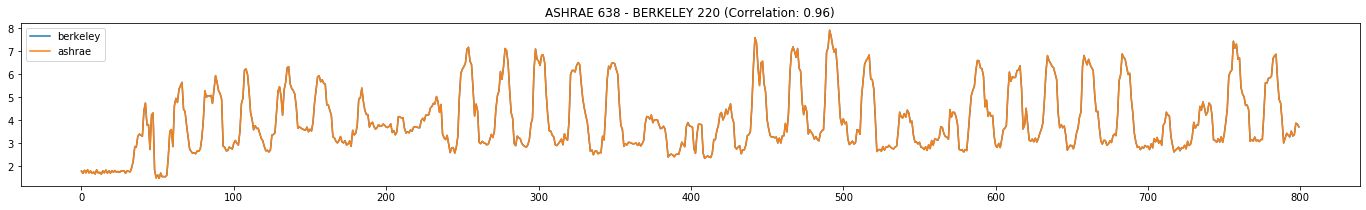

------------------------------------
28 . berkeley  221  is highly correlated to ashrae  595  with score  0.956262217138954
mae:  12.761802326084482  whereas mean:  232.88370237959697  mae / mean:  5.479903572334544 %


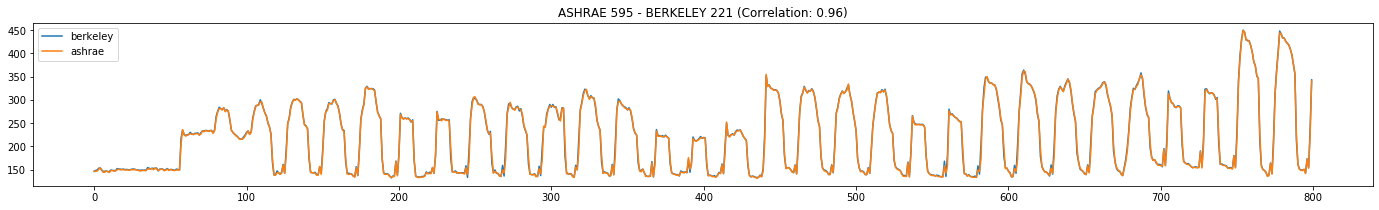

------------------------------------
29 . berkeley  222  is highly correlated to ashrae  611  with score  0.9624050127314411
mae:  6.346799408919302  whereas mean:  518.3467836243511  mae / mean:  1.2244311355694384 %


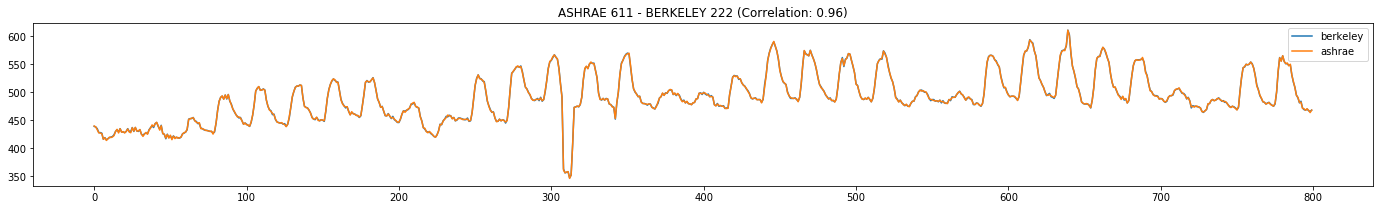

------------------------------------
30 . berkeley  224  is highly correlated to ashrae  569  with score  0.9493424723586076
mae:  11.263725622224753  whereas mean:  327.84296698166906  mae / mean:  3.435707566316208 %


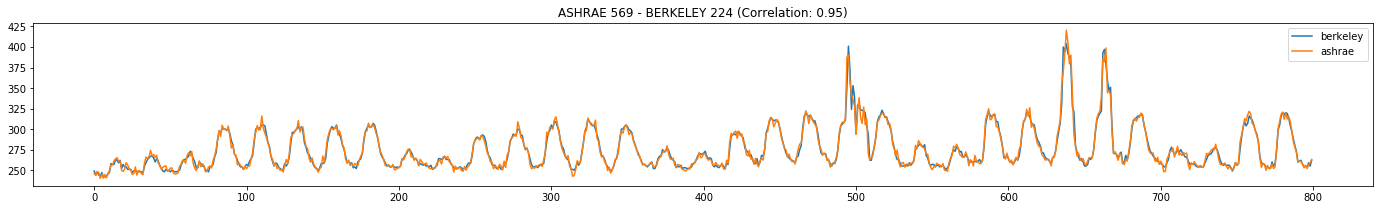

------------------------------------
31 . berkeley  226  is highly correlated to ashrae  645  with score  0.9712123288300115
mae:  21.23462855726496  whereas mean:  1538.9678545868944  mae / mean:  1.3797967575459837 %


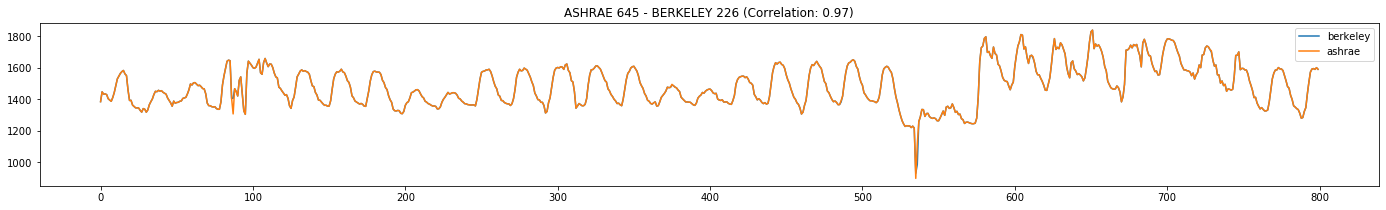

------------------------------------
32 . berkeley  228  is highly correlated to ashrae  607  with score  0.9330348851769946
mae:  1.903628479159339  whereas mean:  22.05838812873725  mae / mean:  8.629952778278154 %


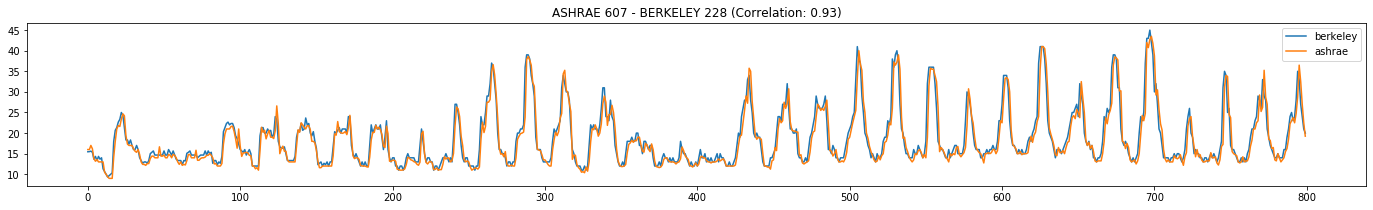

------------------------------------
33 . berkeley  229  is highly correlated to ashrae  606  with score  0.9471558769694264
mae:  0.7453423657142858  whereas mean:  52.66598206857143  mae / mean:  1.4152254195959841 %


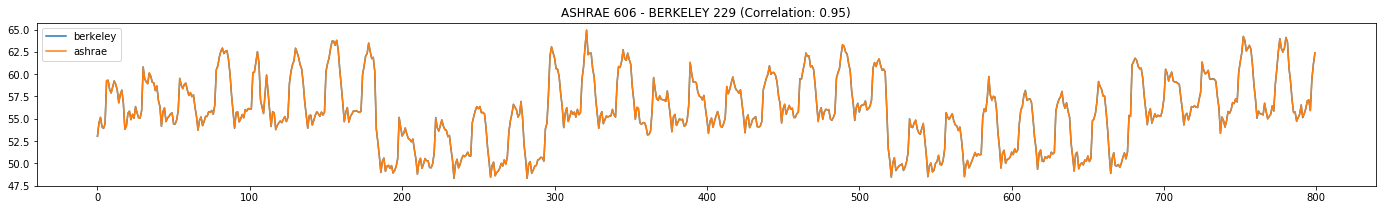

------------------------------------
34 . berkeley  231  is highly correlated to ashrae  626  with score  0.9814483834452359
mae:  3.4871867498878757  whereas mean:  123.9312856181791  mae / mean:  2.813806644943213 %


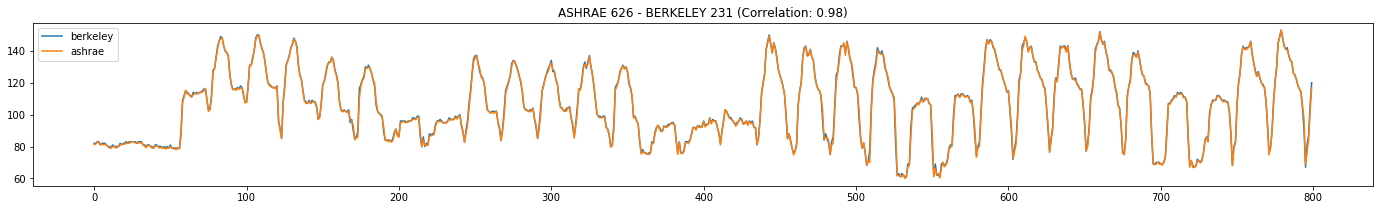

------------------------------------
35 . berkeley  233  is highly correlated to ashrae  632  with score  0.9398401905272507
mae:  1.8985756278062675  whereas mean:  58.576190210826205  mae / mean:  3.2412070859729076 %


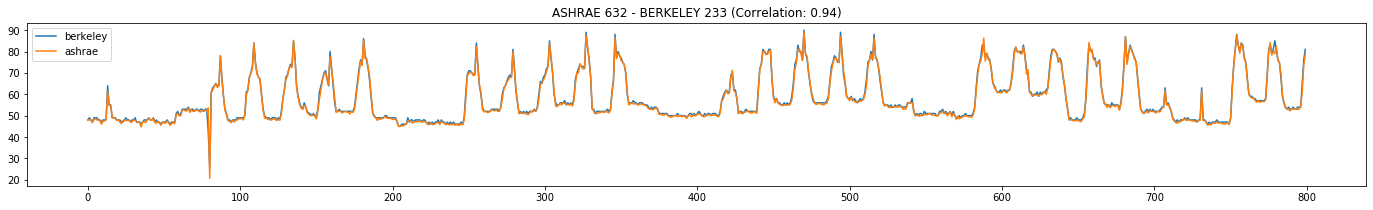

------------------------------------
36 . berkeley  235  is highly correlated to ashrae  610  with score  0.8892953929034692
mae:  3.8332809533189116  whereas mean:  44.041982181486965  mae / mean:  8.703697616339872 %


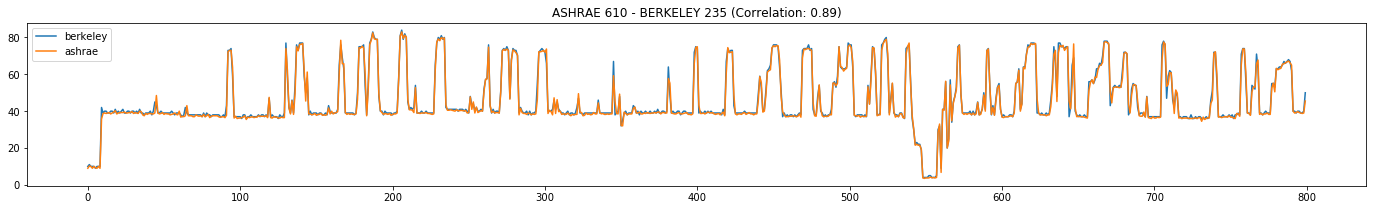

------------------------------------
37 . berkeley  237  is highly correlated to ashrae  628  with score  0.9507023806435905
mae:  1.0436801735739496  whereas mean:  21.387249425025622  mae / mean:  4.8799177156119935 %


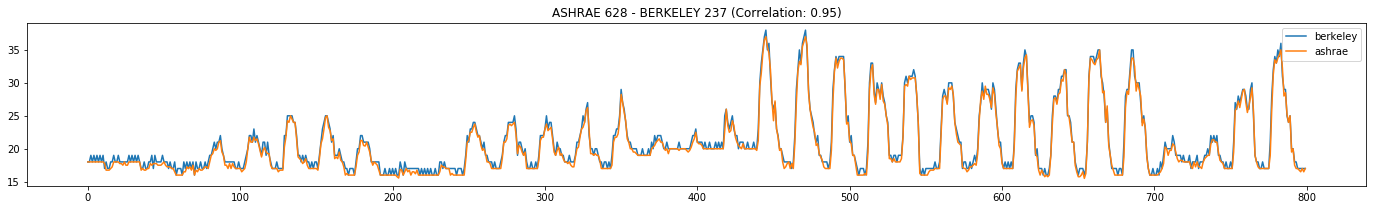

------------------------------------
38 . berkeley  239  is highly correlated to ashrae  575  with score  0.9513835826584991
mae:  2.0337106200250883  whereas mean:  34.682432865777166  mae / mean:  5.863806117338005 %


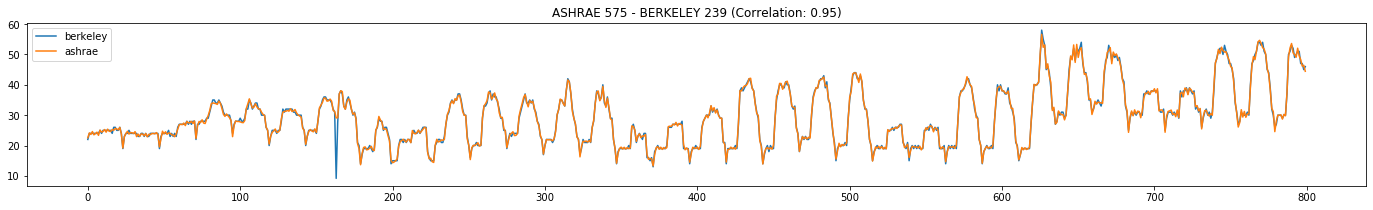

------------------------------------
39 . berkeley  242  is highly correlated to ashrae  588  with score  0.9560185487676691
mae:  1.8264041041557553  whereas mean:  21.877291608789704  mae / mean:  8.348401332374962 %


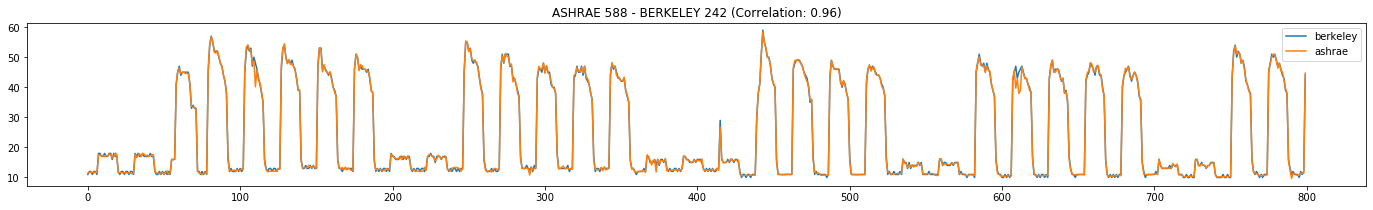

------------------------------------
40 . berkeley  243  is highly correlated to ashrae  570  with score  0.9319433758959228
mae:  7.846396401001939  whereas mean:  153.0206134008881  mae / mean:  5.127672819116016 %


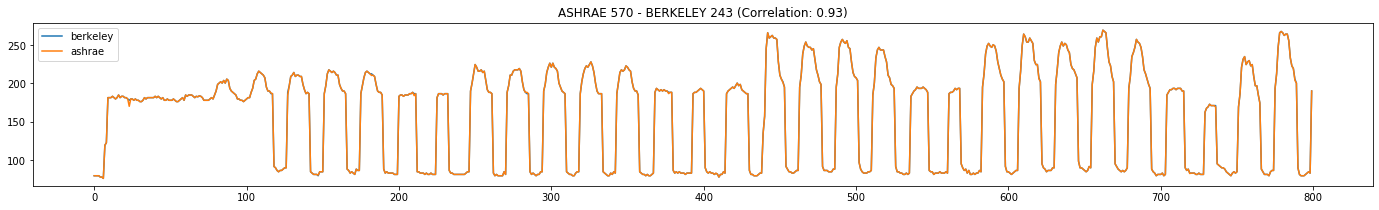

------------------------------------
41 . berkeley  244  is highly correlated to ashrae  571  with score  0.9554015190285956
mae:  3.9858404939086873  whereas mean:  42.05160212911306  mae / mean:  9.47845097951505 %


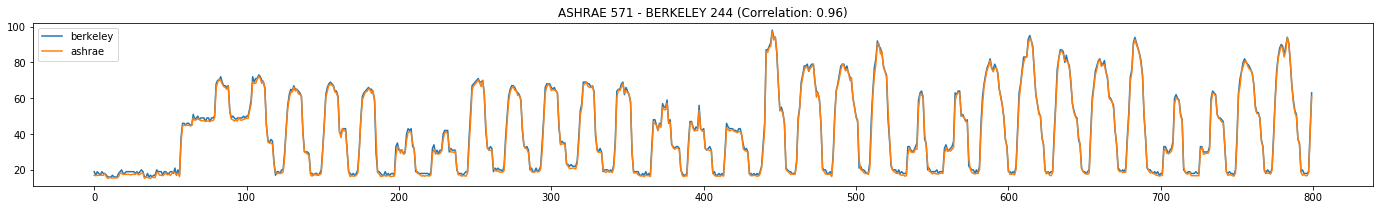

------------------------------------
42 . berkeley  247  is highly correlated to ashrae  574  with score  0.943747757525653
mae:  3.230614346009336  whereas mean:  41.67975637026073  mae / mean:  7.751039419017425 %


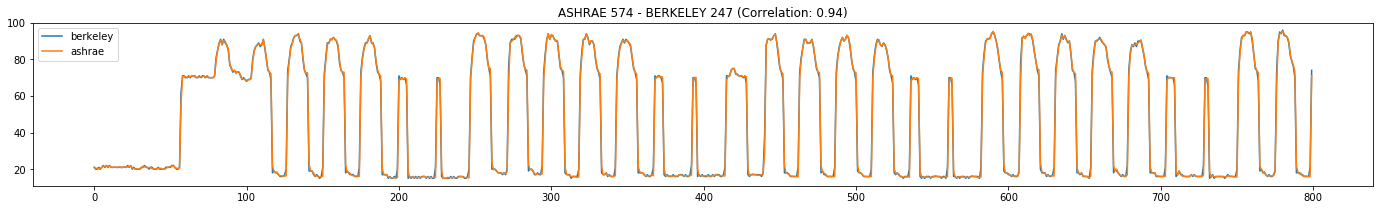

------------------------------------
43 . berkeley  248  is highly correlated to ashrae  583  with score  0.9710993896039674
mae:  16.26544300053605  whereas mean:  522.6366179308496  mae / mean:  3.1121897016959763 %


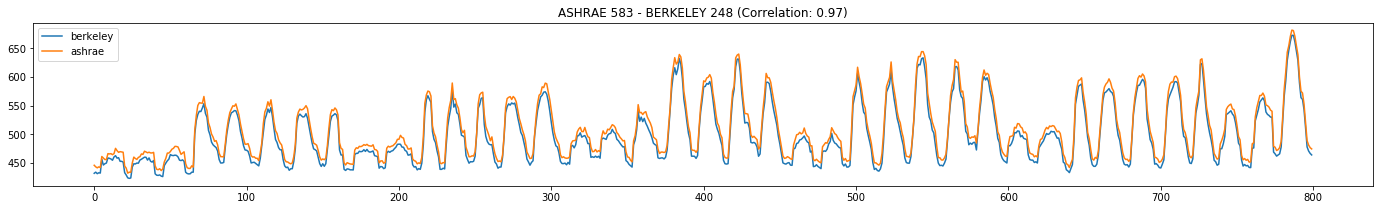

------------------------------------
44 . berkeley  249  is highly correlated to ashrae  584  with score  0.9746139518690906
mae:  6.662642878287602  whereas mean:  142.7023864169418  mae / mean:  4.668907819677923 %


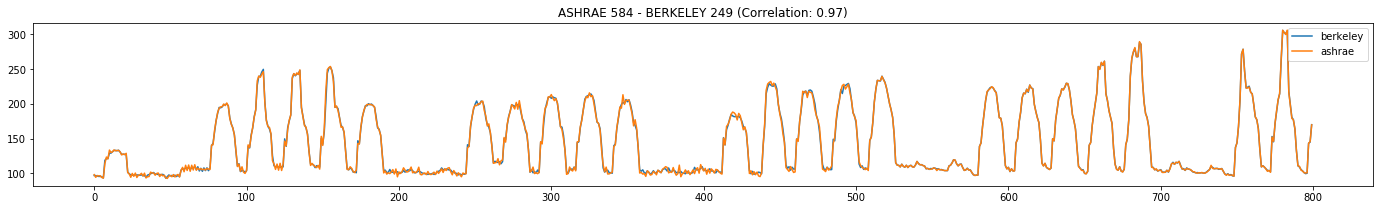

------------------------------------
45 . berkeley  250  is highly correlated to ashrae  586  with score  0.9599396336648862
mae:  8.237954636342936  whereas mean:  113.9601907320961  mae / mean:  7.2288003235350615 %


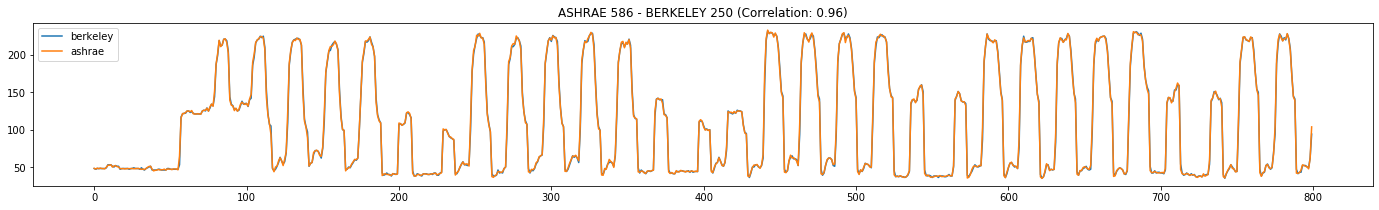

------------------------------------
46 . berkeley  252  is highly correlated to ashrae  585  with score  0.965066734982412
mae:  5.573129747210203  whereas mean:  207.4350721931223  mae / mean:  2.6866863391459725 %


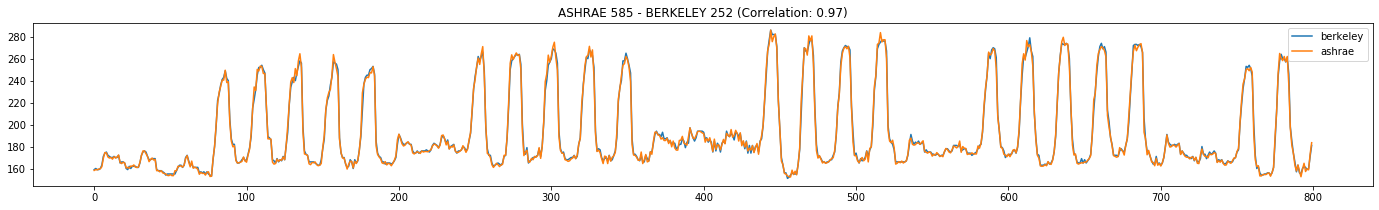

------------------------------------
47 . berkeley  253  is highly correlated to ashrae  587  with score  0.9775547344894612
mae:  1.4699000392022792  whereas mean:  101.42297781196582  mae / mean:  1.4492771469670467 %


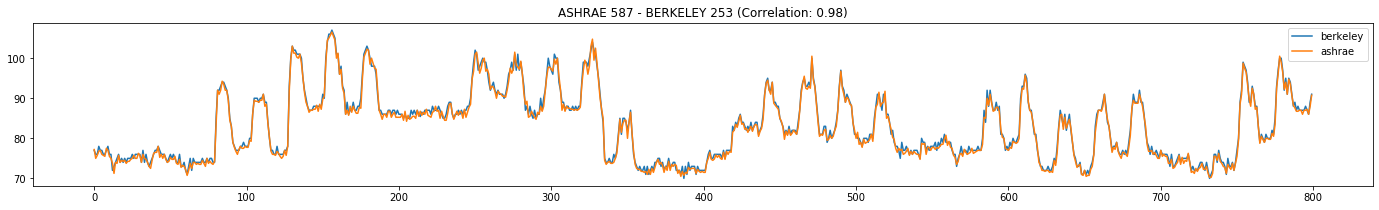

------------------------------------
48 . berkeley  255  is highly correlated to ashrae  589  with score  0.9798214004595216
mae:  5.133838354320847  whereas mean:  125.69653462370489  mae / mean:  4.084311766979028 %


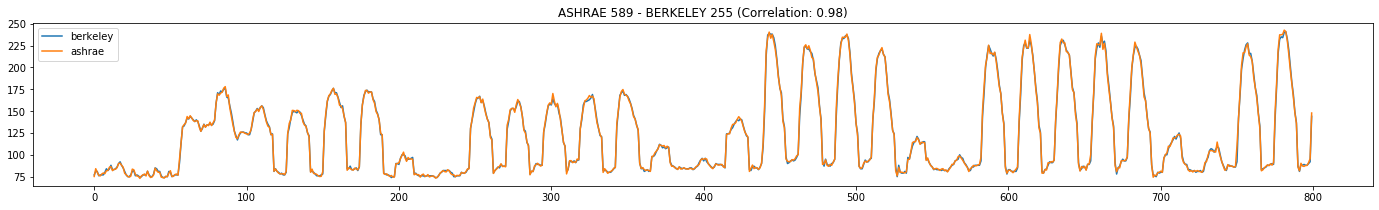

------------------------------------
49 . berkeley  257  is highly correlated to ashrae  594  with score  0.9758876058019254
mae:  5.610541099851986  whereas mean:  381.4954056700444  mae / mean:  1.470670686059204 %


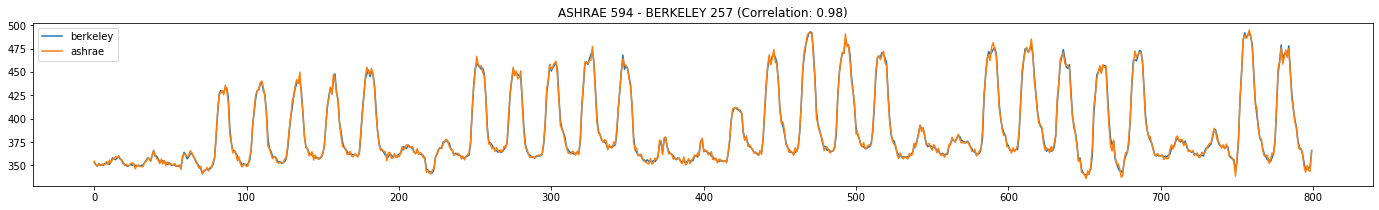

------------------------------------
50 . berkeley  258  is highly correlated to ashrae  600  with score  0.954197641210237
mae:  2.308302552262624  whereas mean:  69.067950131084  mae / mean:  3.3420747942883757 %


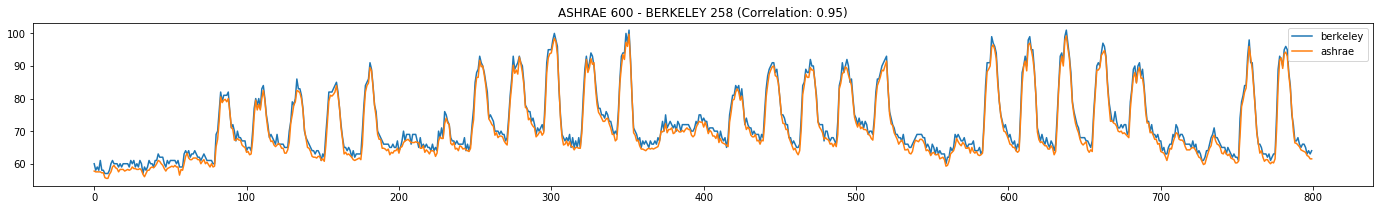

------------------------------------
51 . berkeley  259  is highly correlated to ashrae  597  with score  0.9411003071217532
mae:  13.950319268587045  whereas mean:  181.65780183308667  mae / mean:  7.679449562758153 %


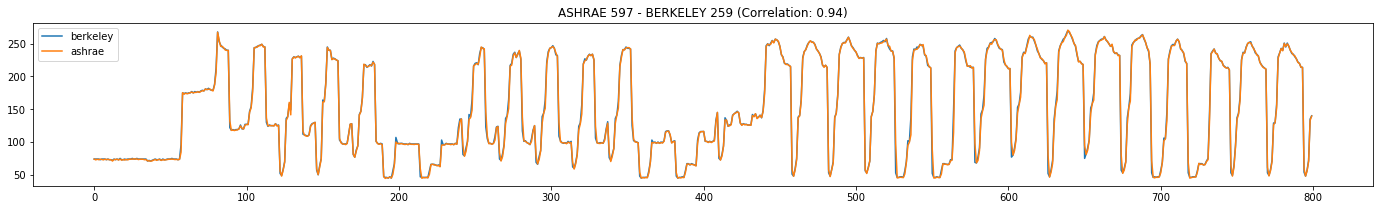

------------------------------------
52 . berkeley  260  is highly correlated to ashrae  601  with score  0.9623916949619298
mae:  1.5414260015165655  whereas mean:  16.224319657022868  mae / mean:  9.500712720790995 %


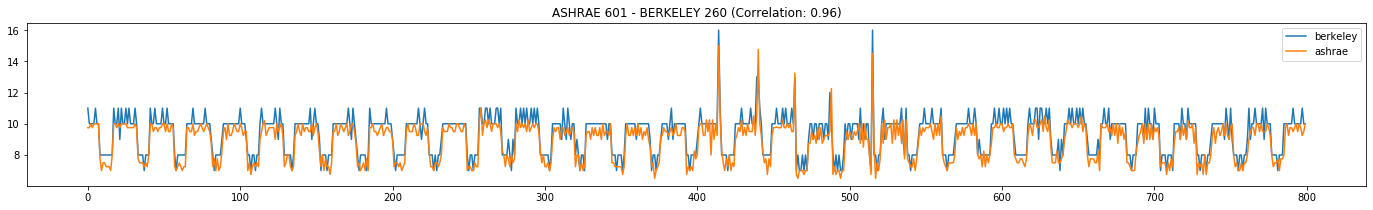

------------------------------------
53 . berkeley  261  is highly correlated to ashrae  598  with score  0.9595319015201264
mae:  1.8649413751565524  whereas mean:  50.42383544347034  mae / mean:  3.6985313765893904 %


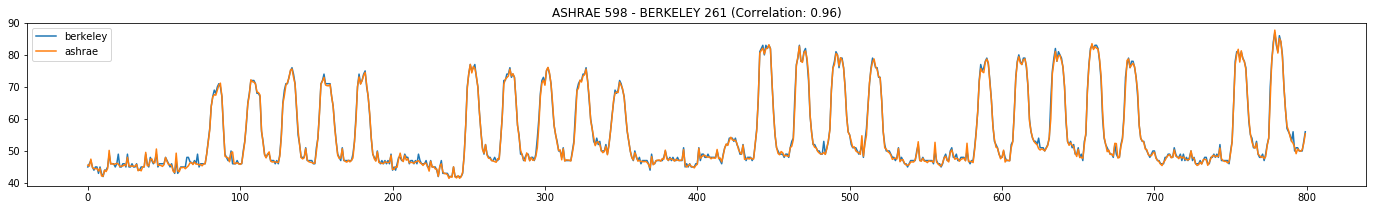

------------------------------------
54 . berkeley  261  is highly correlated to ashrae  630  with score  0.9258249918493623
mae:  3.5182920075162287  whereas mean:  50.45497539004669  mae / mean:  6.9731319464884445 %


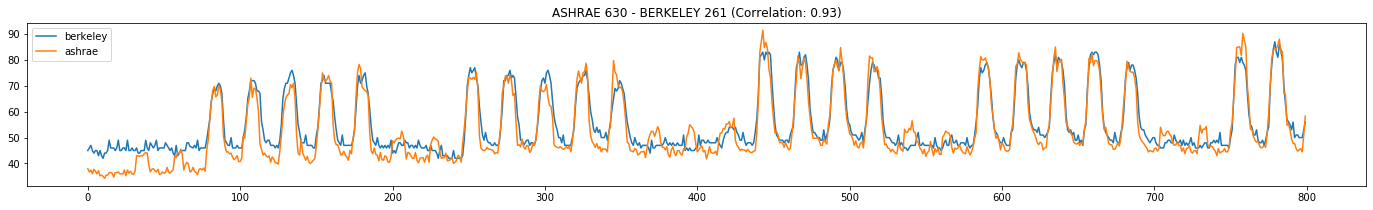

------------------------------------
55 . berkeley  262  is highly correlated to ashrae  580  with score  0.9773171697899041
mae:  5.1390545752020955  whereas mean:  101.69964558806787  mae / mean:  5.053168617733164 %


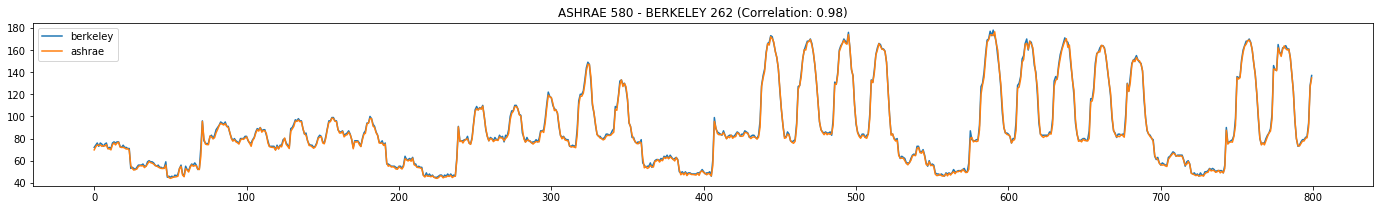

------------------------------------
56 . berkeley  263  is highly correlated to ashrae  602  with score  0.9616355847186857
mae:  17.473960075280115  whereas mean:  528.7431952030812  mae / mean:  3.304810394499482 %


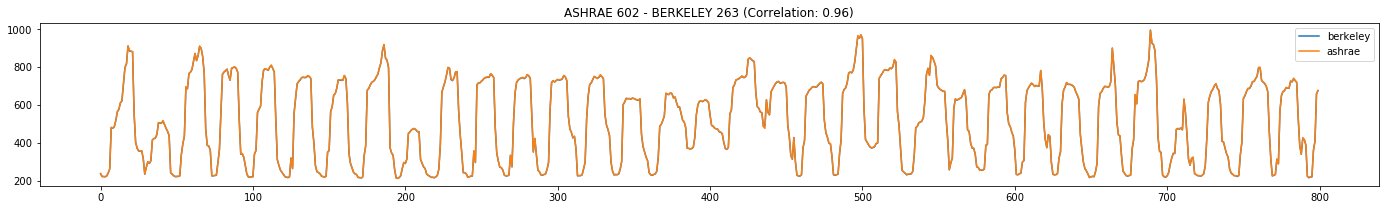

------------------------------------
57 . berkeley  264  is highly correlated to ashrae  614  with score  0.9330665837492934
mae:  11.966257598770353  whereas mean:  180.37461653193668  mae / mean:  6.634113950646507 %


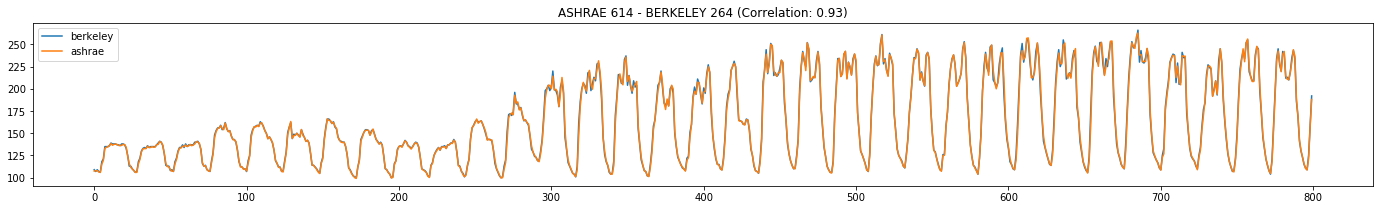

------------------------------------
58 . berkeley  266  is highly correlated to ashrae  603  with score  0.9616325734439163
mae:  2.495839654559945  whereas mean:  38.08926898554025  mae / mean:  6.5526058153214635 %


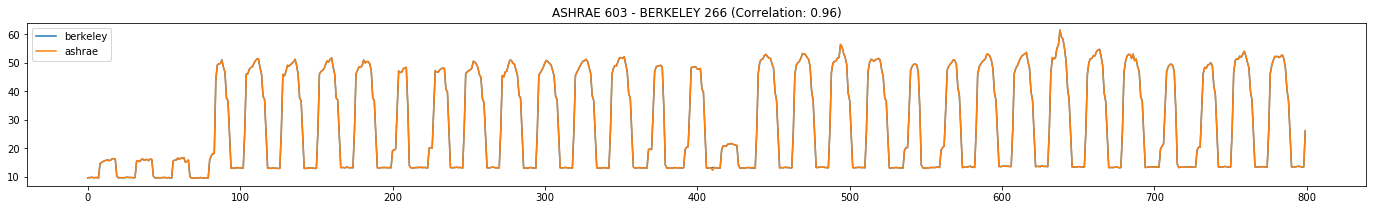

------------------------------------
59 . berkeley  267  is highly correlated to ashrae  605  with score  0.9578842687767389
mae:  1.8911216841625866  whereas mean:  24.158665626779005  mae / mean:  7.8279227560745195 %


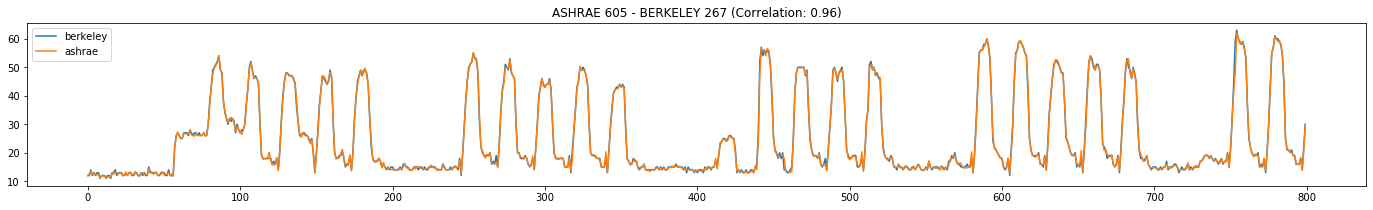

------------------------------------
60 . berkeley  268  is highly correlated to ashrae  608  with score  0.9750297110267471
mae:  1.6352395958100876  whereas mean:  68.397026744848  mae / mean:  2.390805088516895 %


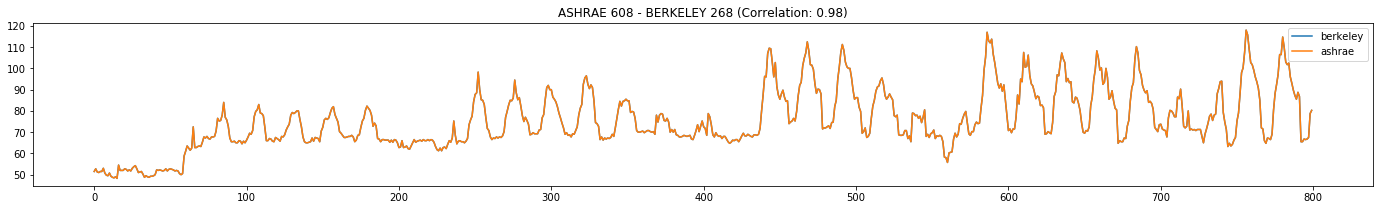

------------------------------------
61 . berkeley  269  is highly correlated to ashrae  609  with score  0.9248809291284624
mae:  8.578413950125256  whereas mean:  489.9607401503074  mae / mean:  1.7508370053269204 %


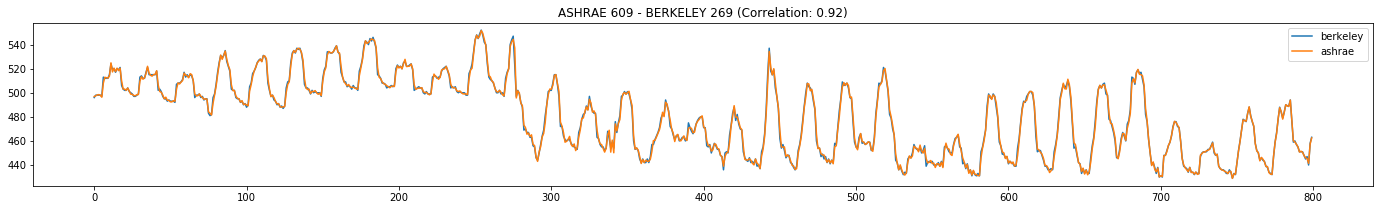

------------------------------------
62 . berkeley  270  is highly correlated to ashrae  612  with score  0.9468661879000446
mae:  2.406415001708623  whereas mean:  88.20668612598247  mae / mean:  2.7281548682960675 %


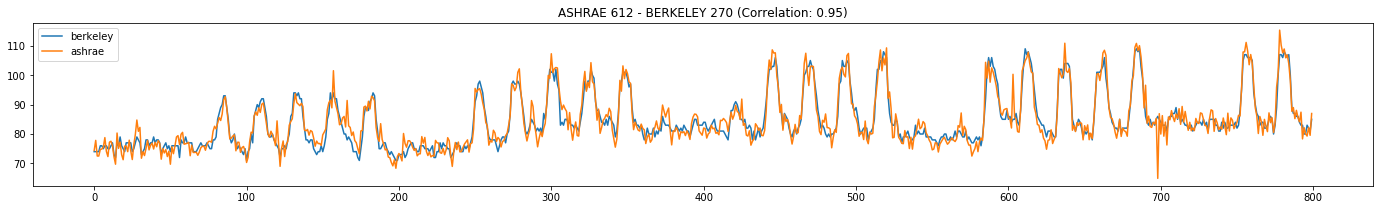

------------------------------------
63 . berkeley  272  is highly correlated to ashrae  615  with score  0.9730003606047035
mae:  10.403864326079525  whereas mean:  814.159847100376  mae / mean:  1.2778650731957375 %


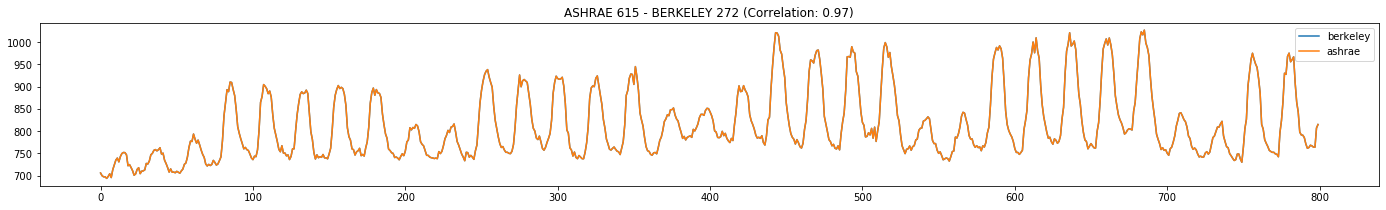

------------------------------------
64 . berkeley  273  is highly correlated to ashrae  616  with score  0.9496975636105802
mae:  5.524823585449163  whereas mean:  67.58963691221678  mae / mean:  8.174069040531501 %


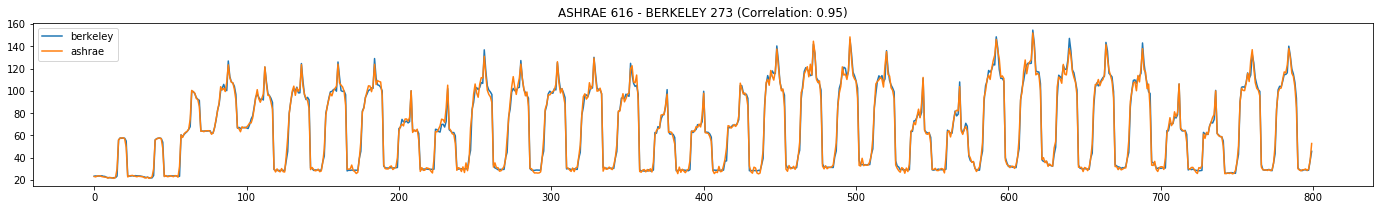

------------------------------------
65 . berkeley  274  is highly correlated to ashrae  617  with score  0.9670642734035537
mae:  11.033391323010365  whereas mean:  623.5112756461345  mae / mean:  1.769557625333502 %


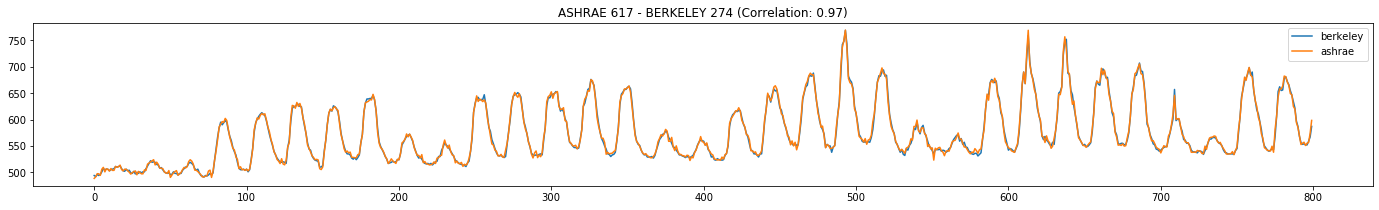

------------------------------------
66 . berkeley  276  is highly correlated to ashrae  567  with score  0.9677980993740876
mae:  4.874579046176046  whereas mean:  161.98627148629149  mae / mean:  3.0092544272114874 %


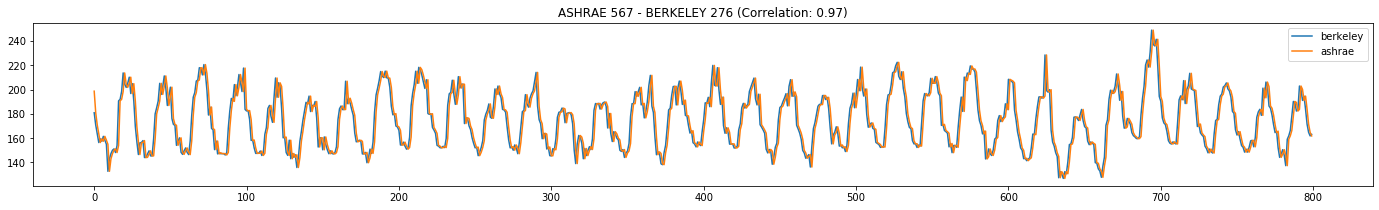

------------------------------------
67 . berkeley  277  is highly correlated to ashrae  618  with score  0.9671342789827307
mae:  5.218234878515314  whereas mean:  119.24380860753729  mae / mean:  4.376105509754302 %


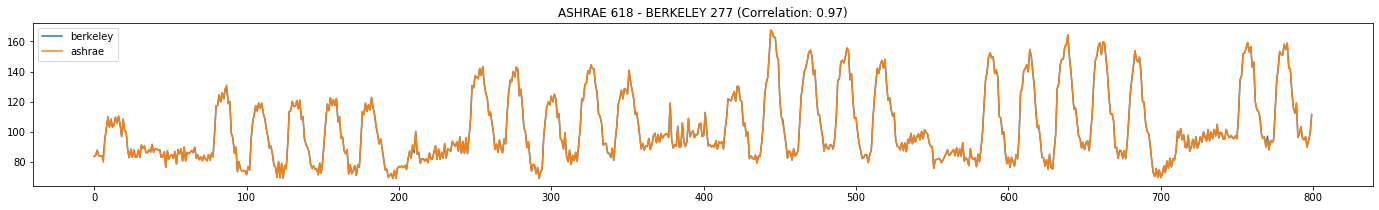

------------------------------------
68 . berkeley  279  is highly correlated to ashrae  619  with score  0.9676267839445486
mae:  3.687544272976055  whereas mean:  184.21637480045612  mae / mean:  2.0017461949136806 %


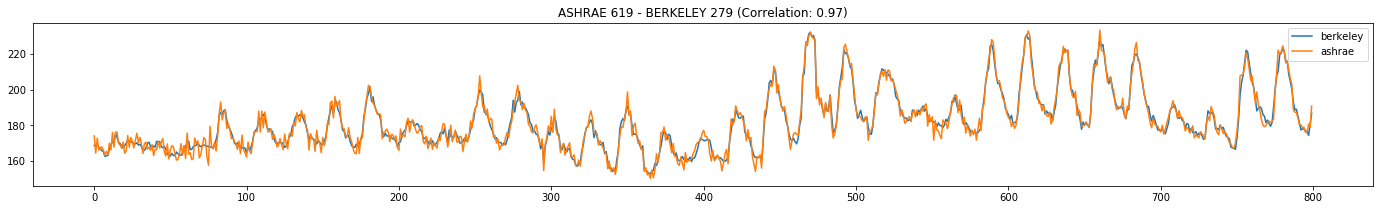

------------------------------------
69 . berkeley  281  is highly correlated to ashrae  604  with score  0.9995473081825119
mae:  0.004425646753016688  whereas mean:  1.5296590909090912  mae / mean:  0.28932242349414494 %


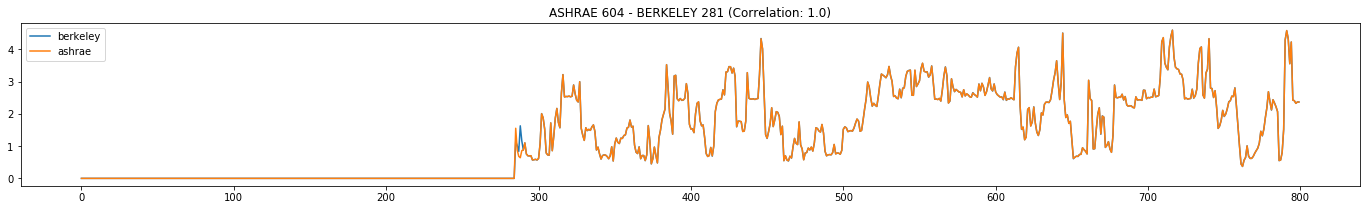

------------------------------------
70 . berkeley  282  is highly correlated to ashrae  622  with score  0.9416011772274198
mae:  7.245783959922578  whereas mean:  216.4744210406467  mae / mean:  3.34717789062111 %


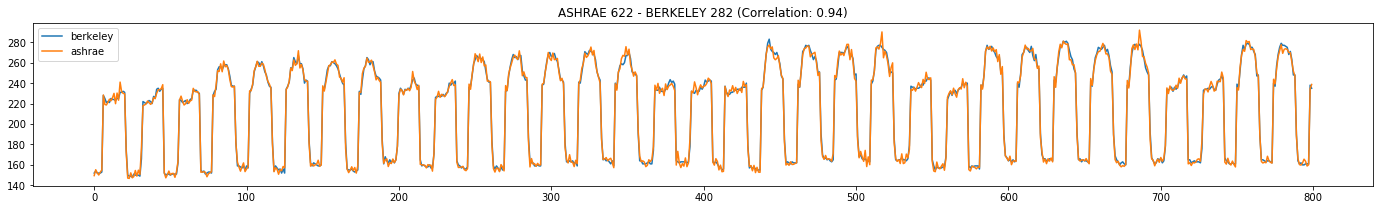

------------------------------------
71 . berkeley  286  is highly correlated to ashrae  577  with score  0.9641833104160109
mae:  2.565598690749509  whereas mean:  56.93053589329022  mae / mean:  4.5065423159873825 %


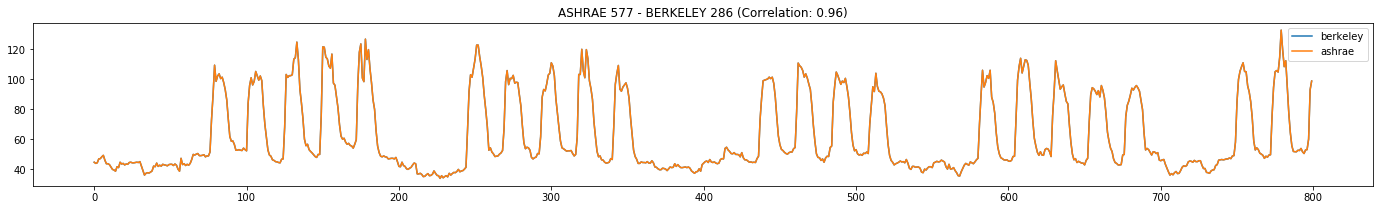

------------------------------------
72 . berkeley  287  is highly correlated to ashrae  627  with score  0.9698228367045356
mae:  2.3070047254754584  whereas mean:  112.15883585013098  mae / mean:  2.056908586817116 %


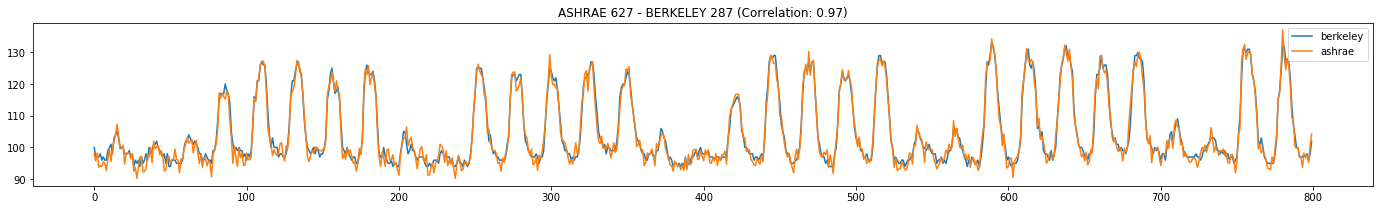

------------------------------------
73 . berkeley  288  is highly correlated to ashrae  598  with score  0.8663452069207976
mae:  4.537454161826255  whereas mean:  50.42383544347034  mae / mean:  8.998629560643298 %


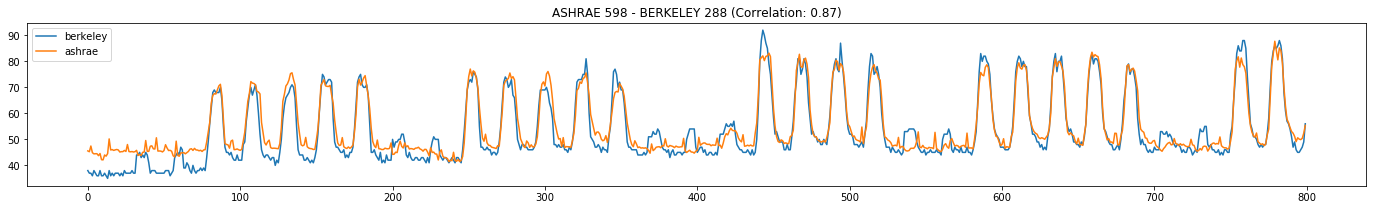

------------------------------------
74 . berkeley  288  is highly correlated to ashrae  630  with score  0.9701507074024137
mae:  1.8798920143673843  whereas mean:  50.45497539004669  mae / mean:  3.7258803514117513 %


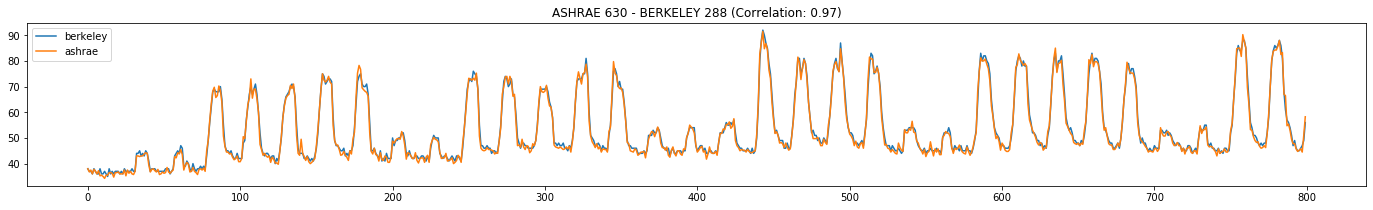

------------------------------------
75 . berkeley  289  is highly correlated to ashrae  640  with score  0.9683754817478184
mae:  11.38974177388136  whereas mean:  258.65064955026753  mae / mean:  4.403523360055517 %


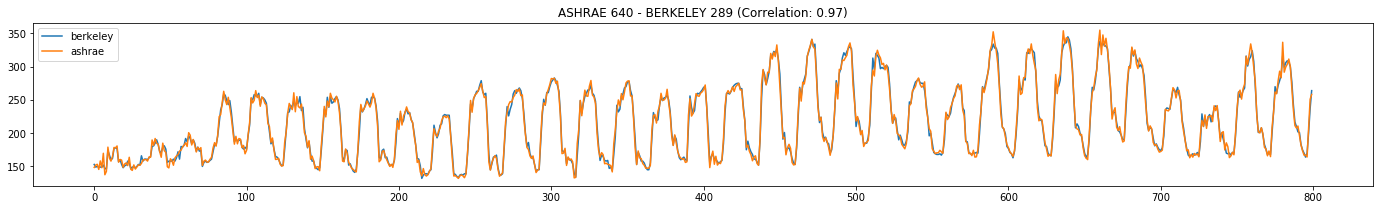

------------------------------------
76 . berkeley  291  is highly correlated to ashrae  633  with score  0.9326385699182017
mae:  0.10734473735763128  whereas mean:  27.61405684510251  mae / mean:  0.38873222417034825 %


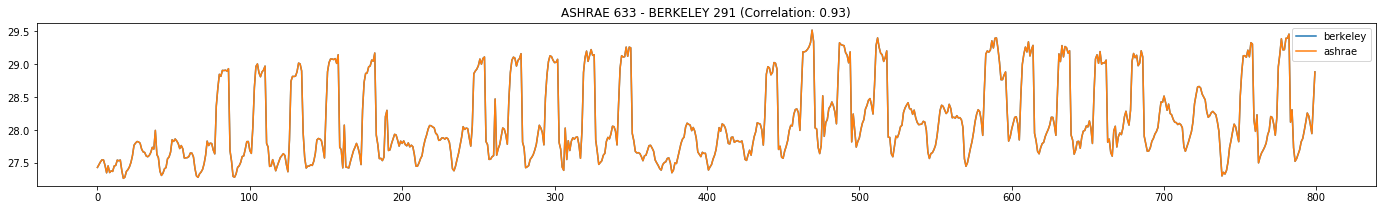

------------------------------------


In [51]:
lookup_list = [] #this will store ashrae id and berkeley id matching

leak_validation = leak[leak.timestamp.dt.year == 2016] #We can confirm Berkeley data with ASHRAE 2016 data

matched = 0; index = 0

for i in berkeley_buildings:
    for j in ashrae_buildings:
        
        df1 = leak_validation[(leak_validation.berkeley_id == i)]
        df2 = train_df[train_df.building_id == j]
        
        tmp = df1.merge(df2, on = ['timestamp'], how='left')
        tmp = tmp.dropna()
        correlation = tmp[['meter_reading_x', 'meter_reading_y']].corr(method ='pearson').values[0,1]
        
        mean = tmp.meter_reading_y.mean()
        mae = abs(tmp.meter_reading_x - tmp.meter_reading_y).sum()/tmp.shape[0]
        mae_over_mean = 100*mae/mean
        
#         print(i," ",j," (",correlation,")")
        
        if correlation >= correlation_threshold and mae_over_mean <= mae_correlation:
            matched = matched + 1
            print(matched,". berkeley ",i," is highly correlated to ashrae ",j," with score ",correlation)
            print("mae: ",mae," whereas mean: ",mean," mae / mean: ",100*mae/mean,"%")
            
            lookup_item = []
            lookup_item.append(i)
            lookup_item.append(j)
            lookup_item.append(mae)
            lookup_list.append(lookup_item)
            
            fig, ax = plt.subplots(figsize=(24, 3))
            plt.title("ASHRAE %s - BERKELEY %s (Correlation: %s)"%(j, i,round(correlation, 2)))
            
            if tmp.meter_reading_x.values[0:800].shape[0] > 0:
                berkeley_graph = tmp.meter_reading_x.values[0:800]
                ashrae_graph = tmp.meter_reading_y.values[0:800]
            else:
                berkeley_graph = tmp.meter_reading_x.values
                ashrae_graph = tmp.meter_reading_y.values
                
            plt.plot(berkeley_graph, label='berkeley')    
            plt.plot(ashrae_graph, label='ashrae')
            plt.legend()
            plt.show()
            
            print("------------------------------------")
            
        index = index + 1

In [23]:
building_lookup = pd.DataFrame(lookup_list, columns=['berkeley_id', 'ashrae_id', 'mae'])

NameError: name 'lookup_list' is not defined

In [53]:
building_lookup.head()

berkeley_id  ashrae_id        mae
0          176        641  10.155284
1          177        643   3.314373
2          178        646   2.918958
3          179        621   1.168564
4          180        649   7.731303

There are some duplicates (e.g. 598 or 630)

In [54]:
building_lookup[(building_lookup.ashrae_id == 630) | (building_lookup.ashrae_id == 598)]

berkeley_id  ashrae_id       mae
52          261        598  1.864941
53          261        630  3.518292
72          288        598  4.537454
73          288        630  1.879892

 We will dismiss buildings having high error

In [55]:
building_lookup_best = building_lookup.groupby("ashrae_id", as_index=False)["mae"].min()

In [56]:
building_lookup = building_lookup.merge(building_lookup_best, on =["ashrae_id", "mae"], how="inner")

In [57]:
building_lookup.head()

berkeley_id  ashrae_id        mae
0          176        641  10.155284
1          177        643   3.314373
2          178        646   2.918958
3          179        621   1.168564
4          180        649   7.731303

In [58]:
print("There are ",building_lookup.shape[0]," buildings in Berkeley data set matched with ASHRAE data set")

There are  74  buildings in Berkeley data set matched with ASHRAE data set


In [59]:
# leak = leak.merge(building_lookup, on=['berkeley_id'], how='left')

In [60]:
# leak = leak[leak.ashrae_id > 0]

In [139]:
leak2 = leak2.merge(building_lookup, on='berkeley_id')

In [140]:
leak2 = leak2[leak2.ashrae_id > 0]

In [141]:
len(leak2.ashrae_id.unique())

74

In [142]:
leak2.head()

berkeley_id           timestamp  meter_reading  ashrae_id        mae
0          176 2016-01-01 00:00:00        358.548        641  10.155284
1          176 2016-01-01 01:00:00        355.919        641  10.155284
2          176 2016-01-01 02:00:00        328.179        641  10.155284
3          176 2016-01-01 03:00:00        326.403        641  10.155284
4          176 2016-01-01 04:00:00        325.490        641  10.155284

In [143]:
site4 = leak2.copy()

**For the 74 building matches:**
- **ASHRAE Building ID = Building ID**
- **Meter Reading = Scraped Meter Reading**

In [144]:
site4 = site4.drop(columns = ['berkeley_id'])
site4 = site4.rename(columns = {"ashrae_id": "building_id", "meter_reading": "meter_reading_scraped"})
site4['building_id'] = site4['building_id'].astype('int32')

In [145]:
site4 = site4[['building_id', 'timestamp', 'meter_reading_scraped']]

In [146]:
site4.sample(10)

building_id           timestamp  meter_reading_scraped
1121312          606 2018-08-19 09:00:00               53.75000
465873           636 2018-04-01 10:00:00                0.09000
1465674          583 2018-10-06 19:00:00              504.73206
899641           638 2016-11-01 02:00:00                2.32000
2008696          608 2018-01-25 16:00:00               95.00000
1655557          594 2016-12-07 13:00:00              493.00000
730773           599 2017-02-22 21:00:00              169.00000
2201249          567 2016-07-17 18:00:00                    NaN
1664834          594 2017-12-29 02:00:00              312.00000
43357            643 2017-01-11 13:00:00              120.00000

In [149]:
site4['building_id'].nunique()

74

## Save Dataset as Pickle File

**This pickle file will be used in the "Meter_Reading_Imputing" and "Meter_Reading_Imputing_R1" notebooks.**

In [151]:
berkeley_data = site4.sort_values(by='timestamp').reset_index(drop=True)

In [157]:
with open('berkeley_matched_readings.pkl', 'wb') as to_write:
    pickle.dump(berkeley_data, to_write)